In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-05-02 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19), the data behind the dashboard: [Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

It seems that there are currently [data-changes](https://github.com/CSSEGISandData/COVID-19/commit/0cea9b2179306618bd7917798819ebf6608d67de#comments) in progress that cause issues. This is mostly an issue for the US data, so that I comment it out. The US data as used in this notebook **is currently wrong**.

In [5]:
covid19.time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30


In [6]:
covid19.time_series_19_covid_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,5,5,10,10,10,15,18,18,29,32,32,32,32,32,40,43,54,99,112,131,135,150,166,179,188,188,207,220,228,252,260,310
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31,33,44,52,67,76,89,99,104,116,131,154,165,182,197,217,232,248,251,277,283,302,314,327,345,356,385,394,403,410,422,431,455,470,488
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31,31,37,46,61,61,62,90,90,90,113,237,347,405,460,591,601,691,708,783,846,894,1047,1099,1152,1204,1355,1408,1479,1508,1558,1651,1702,1779,1821
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10,10,10,10,16,21,26,31,39,52,58,71,71,128,128,128,169,169,191,205,235,248,282,309,333,344,344,344,385,398,423,468,468
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,4,4,4,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,7,7,11


In [7]:
df = covid19.get_cases_by_region(region='China')
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-27,83918,78374,4637,6,97,0
2020-04-28,83940,78422,4637,22,48,0
2020-04-29,83944,78474,4637,4,52,0
2020-04-30,83956,78523,4637,12,49,0
2020-05-01,83959,78573,4637,3,50,0


* [BAR CHART ANNOTATIONS WITH PANDAS AND MATPLOTLIB](https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html)

In [8]:
df = covid19.get_rki_df()
cbr_germany = covid19.CasesByRegion('Germany', df=df)
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-27,158872,128930,5842,909,0,106
2020-04-28,159732,128930,6054,860,0,212
2020-04-29,160584,128930,6256,852,0,202
2020-04-30,161370,128930,6603,786,0,347
2020-05-01,161653,128930,6736,283,0,133


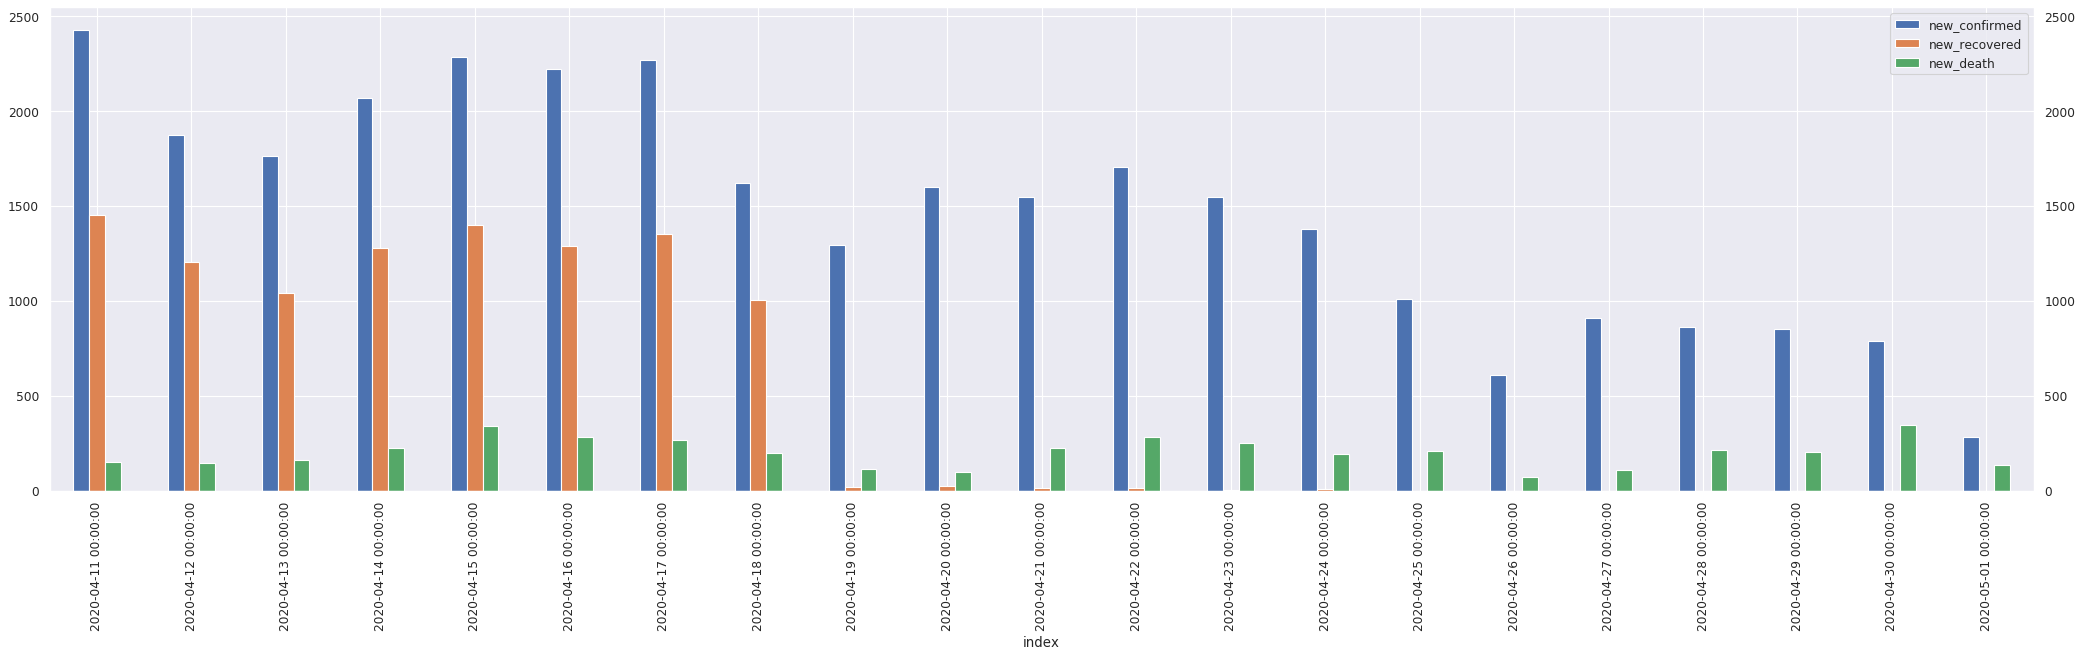

In [9]:
cbr_germany.plot_daily_stats()

[COVID-19-Pandemie#Deutschland](https://de.wikipedia.org/wiki/COVID-19-Pandemie#Deutschland):

> Am 22. März 2020 einigten sich Bund und Länder auf ein „umfassendes Kontaktverbot“, statt weitergehende Ausgangssperren zu beschließen.


> Roughly 2020-04-21 the taken actions show clear effect; roughly 4.5 weeks later.

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate  | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-21 |  92845 | 0.057 | - |
| 2020-04-03 | 2020-04-23 |  99774 | 0.054 | - |
| 2020-04-04 | 2020-04-25 | 107193 | 0.051 | - |
| 2020-04-05 | 2020-04-27 | 114511 | 0.049 | - |
| 2020-04-06 | 2020-04-29 | 119618 | 0.045 | - |
| 2020-04-07 | 2020-04-29 | 121354 | 0.039 | - |
| 2020-04-08 | 2020-04-30 | 123011 | 0.035 | - |
| 2020-04-09 | 2020-04-30 | 125833 | 0.031 | - |
| 2020-04-10 | - | - | 0.049 | 4820 |
| 2020-04-11 | - | - | 0.042 | 4739 |
| 2020-04-12 | - | - | 0.040 | 4570 |
| 2020-04-13 | - | - | 0.036 | 4300 |
| 2020-04-14 | - | - | 0.033 | 3927 |
| 2020-04-15 | - | - | 0.029 | 3451 |
| 2020-04-16 | - | - | 0.026 | 3086 |
| 2020-04-17 | - | - | 0.024 | 2845 |
| 2020-04-19 | - | - | 0.021 | 2666 |
| 2020-04-20 | - | - | 0.020 | 2554 |
| 2020-04-21 | - | - | 0.018 | 2356 |
| 2020-04-24 | - | - | 0.015 | 2043 |
| 2020-04-25 | 2020-05-24 | 166654 | 0.011 | - |
| 2020-04-26 | 2020-05-26 | 167739 | 0.010 | - |
| 2020-04-27 | 2020-05-26 | 168771 | 0.009 | - |
| 2020-04-28 | - | - | 0.013 | 1538 |
| 2020-04-29 | 2020-05-25 | 169856 | 0.008 | - |
| 2020-04-30 | 2020-05-26 | 170081 | 0.007 | - |
| 2020-05-01 | 2020-06-06 | 176154 | 0.007 | - |
| 2020-05-02 | 2020-06-06 | 176278 | 0.006 | - |

In [10]:
cbr_germany.fit(first_date=pd.to_datetime('2020-03-09'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


In [11]:
# cbr_germany.fit_df0.loc[pd.to_datetime('2020-05-24')]

sigmoid+asymmetric: seor: 508.4535760730587, max asymptotic: 176278.2001608488; growth-rate: 0.006, date:2020-06-06 00:00:00, projected value: 91.44740647616838


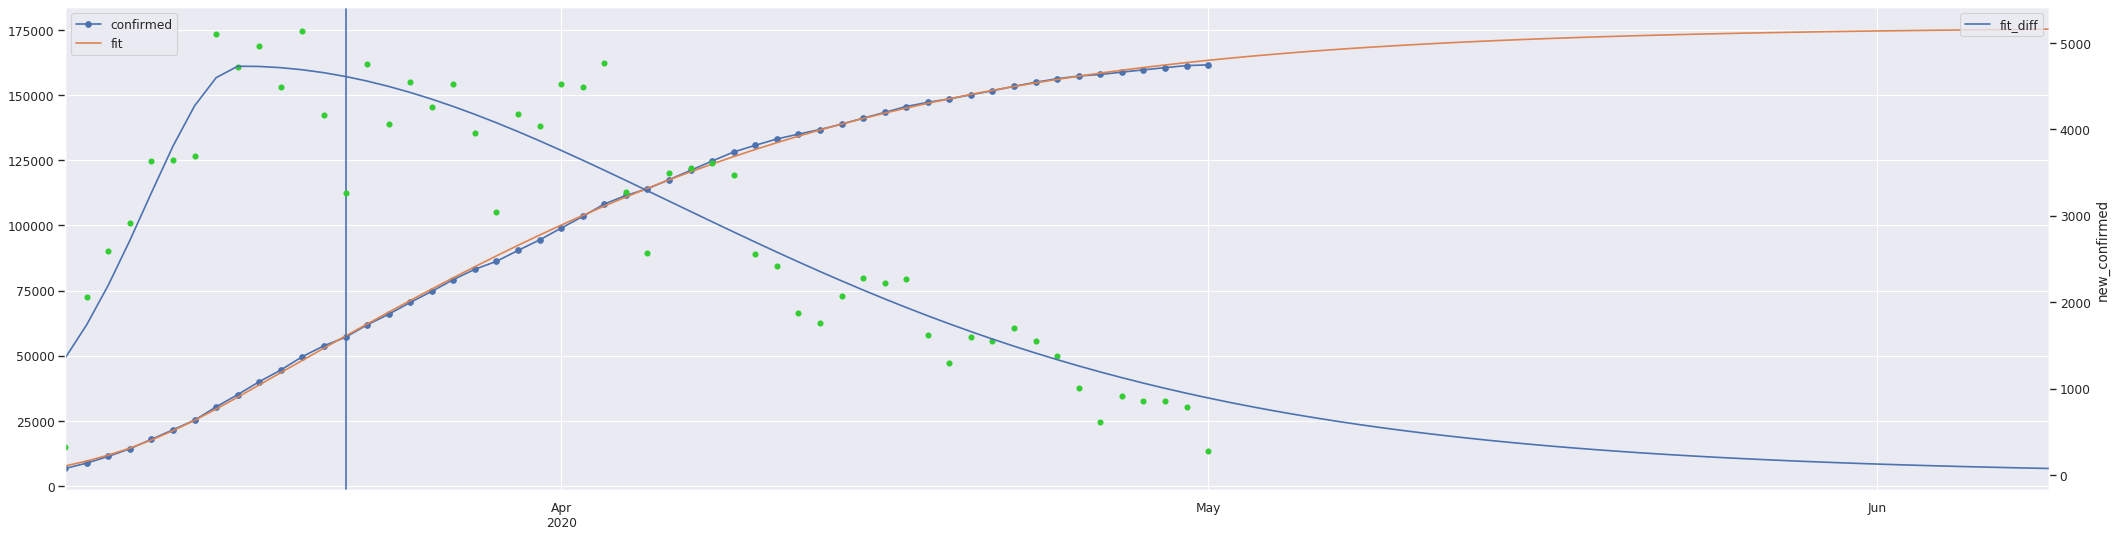

In [12]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [13]:
cbr_germany.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,4730.263696


In [14]:
cbr_germany.calculate_R_estimates()
cbr_germany.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-04-29,0.616,0.479,0.292,0.386,0.494


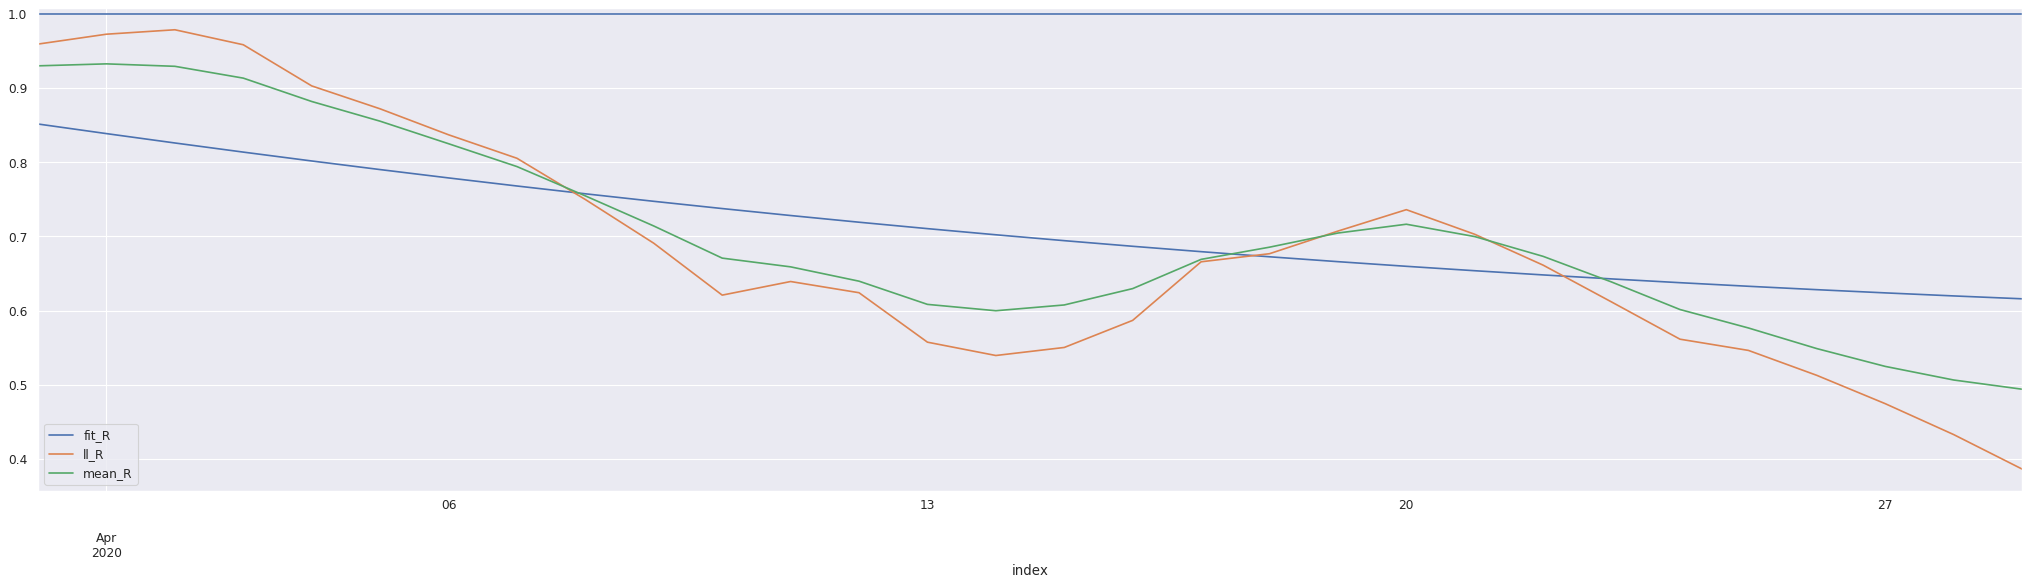

In [15]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [16]:
df = covid19.get_austria_df()
cbr_austria = covid19.CasesByRegion('Austria', df=df)
cbr_austria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-27,15239,12362,536,64,80,16
2020-04-28,15286,12580,543,47,218,7
2020-04-29,15352,12779,554,66,199,11
2020-04-30,15424,12907,557,72,128,3
2020-05-01,15470,13092,561,46,185,4


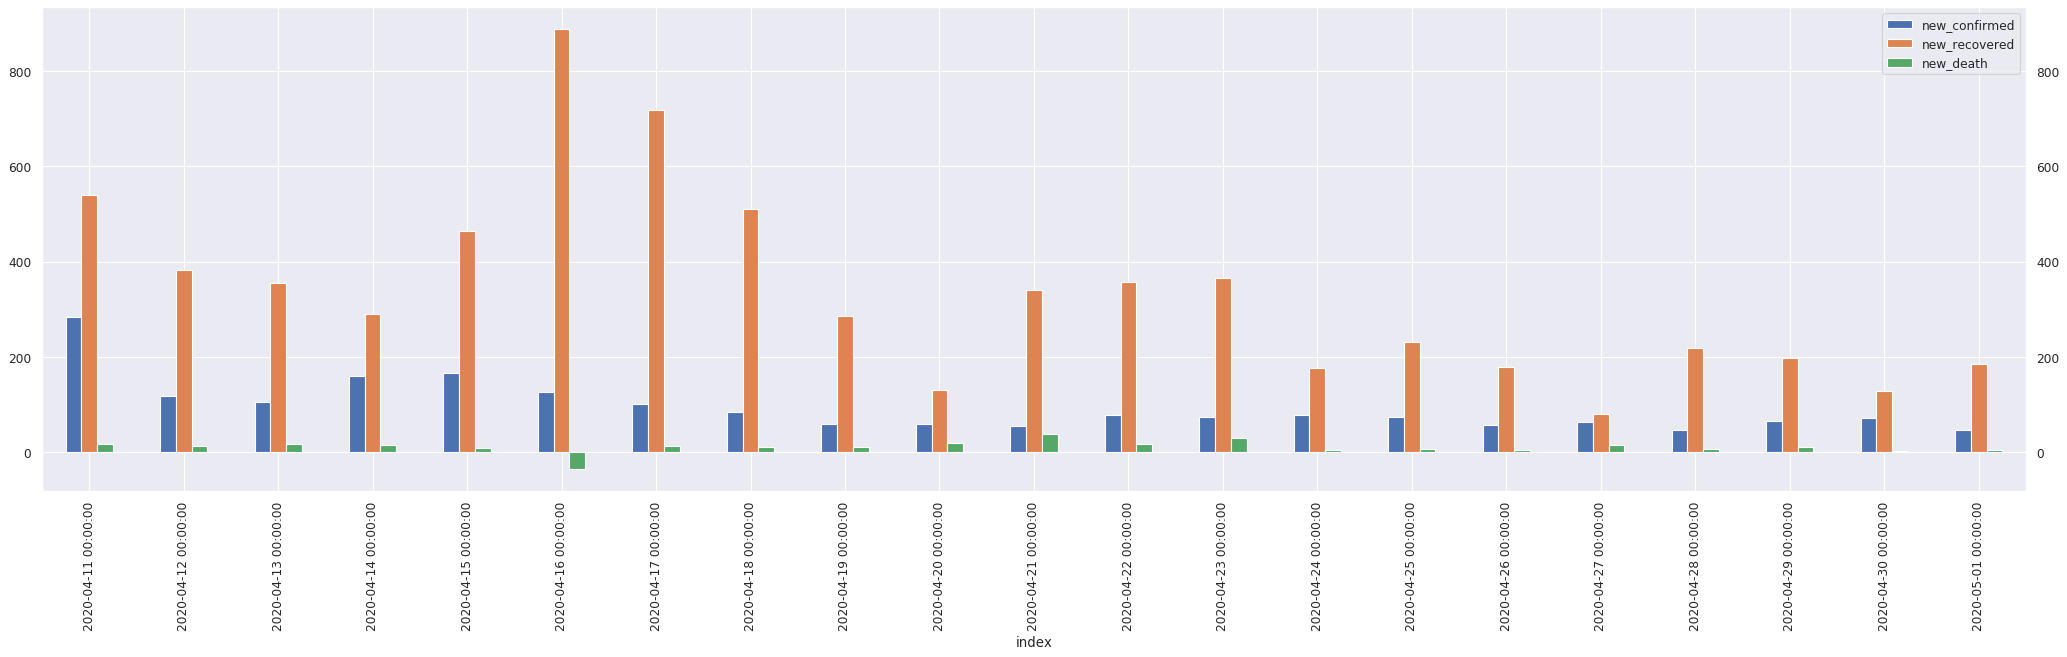

In [17]:
cbr_austria.plot_daily_stats()

[COVID-19-Pandemie#%C3%96sterreich](https://de.wikipedia.org/wiki/COVID-19-Pandemie#%C3%96sterreich)

> Nachdem Mitte März zuerst einzelne Gemeinden unter Quarantäne gestellt wurden, verlautbarte Bundeskanzler Sebastian Kurz am 15. März eine landesweite Ausgangsbeschränkung, verbunden mit einer Einschränkung der Versammlungsfreiheit auf bis zu fünf Personen.

`2020-03-15`

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-12 | 13859 | 0.042 | - |
| 2020-04-03 | 2020-04-12 | 13864 | 0.036 | - |
| 2020-04-04 | 2020-04-12 | 14082 | 0.030 | - |
| 2020-04-05 | 2020-04-12 | 13978 | 0.025 | - |
| 2020-04-06 | 2020-04-11 | 13947 | 0.020 | - |
| 2020-04-07 | 2020-04-12 | 14033 | 0.017 | - |
| 2020-04-08 | 2020-04-12 | 14121 | 0.014 | - |
| 2020-04-09 | 2020-04-12 | 14229 | 0.012 | - |
| 2020-04-10 | 2020-04-12 | 14350 | 0.010 | - |
| 2020-04-11 | 2020-04-13 | 14488 | 0.009 | - |
| 2020-04-12 | - | - | 0.012 | 106 |
| 2020-04-13 | - | - | 0.012 | 123 |
| 2020-04-14 | - | - | 0.011 | 126 |
| 2020-04-15 | - | - | 0.010 | 114 |
| 2020-04-15 | - | - | 0.009 | 107 |
| 2020-04-17 | - | - | 0.009 | 106 |
| 2020-04-19 | - | - | 0.007 |  95 |
| 2020-04-20 | - | - | 0.007 |  87 |
| 2020-04-21 | - | - | 0.006 |  83 |
| 2020-04-24 | - | - | 0.005 |  68 |
| 2020-04-26 | 2020-05-01 | 15208 | 0.002 |  - |
| 2020-04-27 | 2020-05-01 | 15096 | 0.002 |  - |
| 2020-04-28 | 2020-05-01 | 15129 | 0.002 |  - |
| 2020-04-29 | - | - | 0.005 |  84 |
| 2020-04-30 | - | - | 0.005 |  81 |
| 2020-05-01 | - | - | 0.005 |  77 |
| 2020-05-02 | - | - | 0.005 |  76 |

In [18]:
einwohner_deutschland = 83019213.0
einwohner_bayern      = 13076721.0
prozent_bayern        = einwohner_bayern / einwohner_deutschland
einwohner_österreich  =  8793370.0
prozent_österreich    = einwohner_österreich / einwohner_deutschland

austria_new_confirmed_threshold = (100.0 * prozent_österreich) // 1 + 1
austria_new_confirmed_threshold

11.0

In [19]:
cbr_austria.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=austria_new_confirmed_threshold)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 87.09203484862657; growth-rate: 0.005, date:2020-06-09 00:00:00, projected value: 76.04474710389238


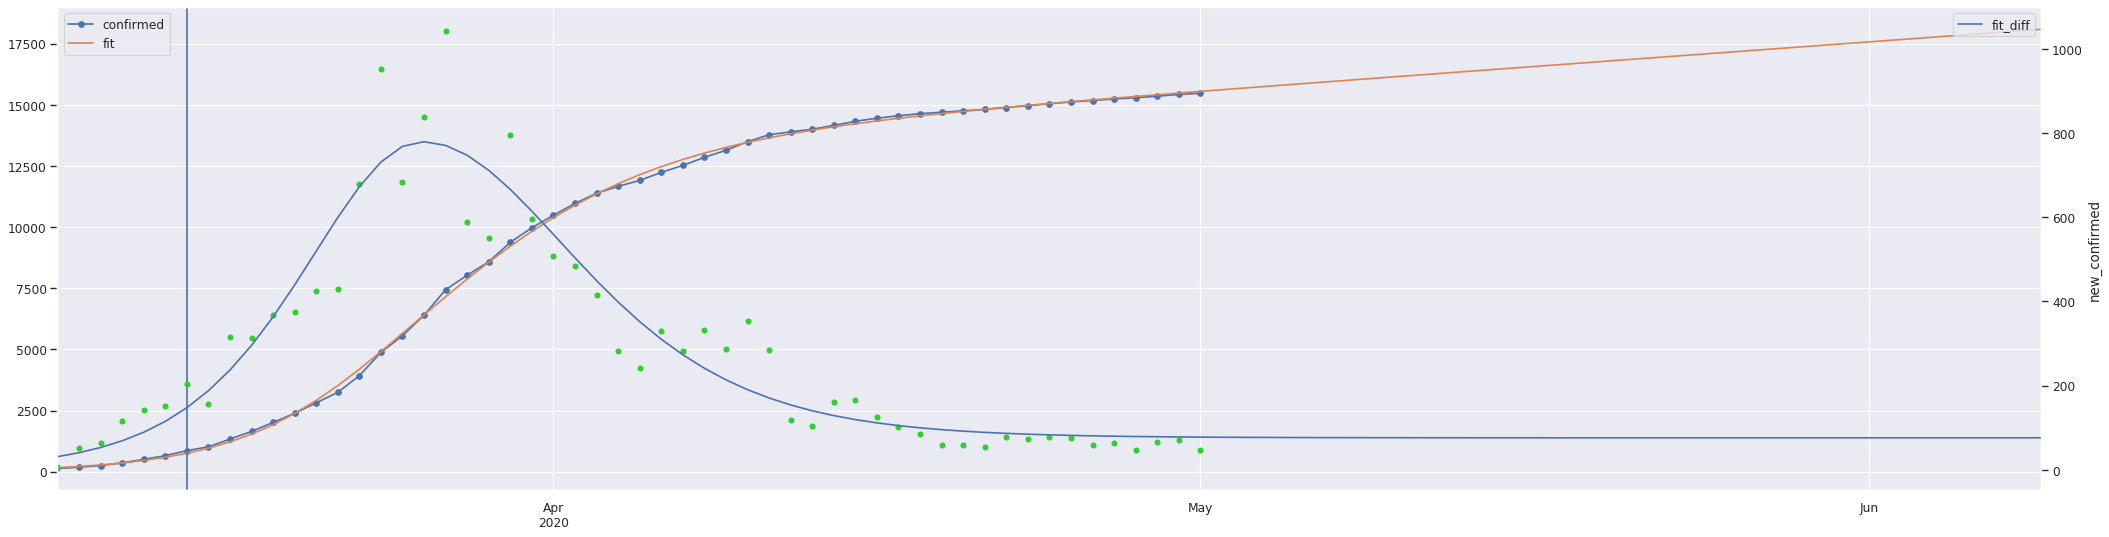

In [20]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_austria.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 15))

In [21]:
cbr_austria.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,779.631724


In [22]:
cbr_austria.calculate_R_estimates()
cbr_austria.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-04-29,0.902,0.969,0.827,0.856,0.909


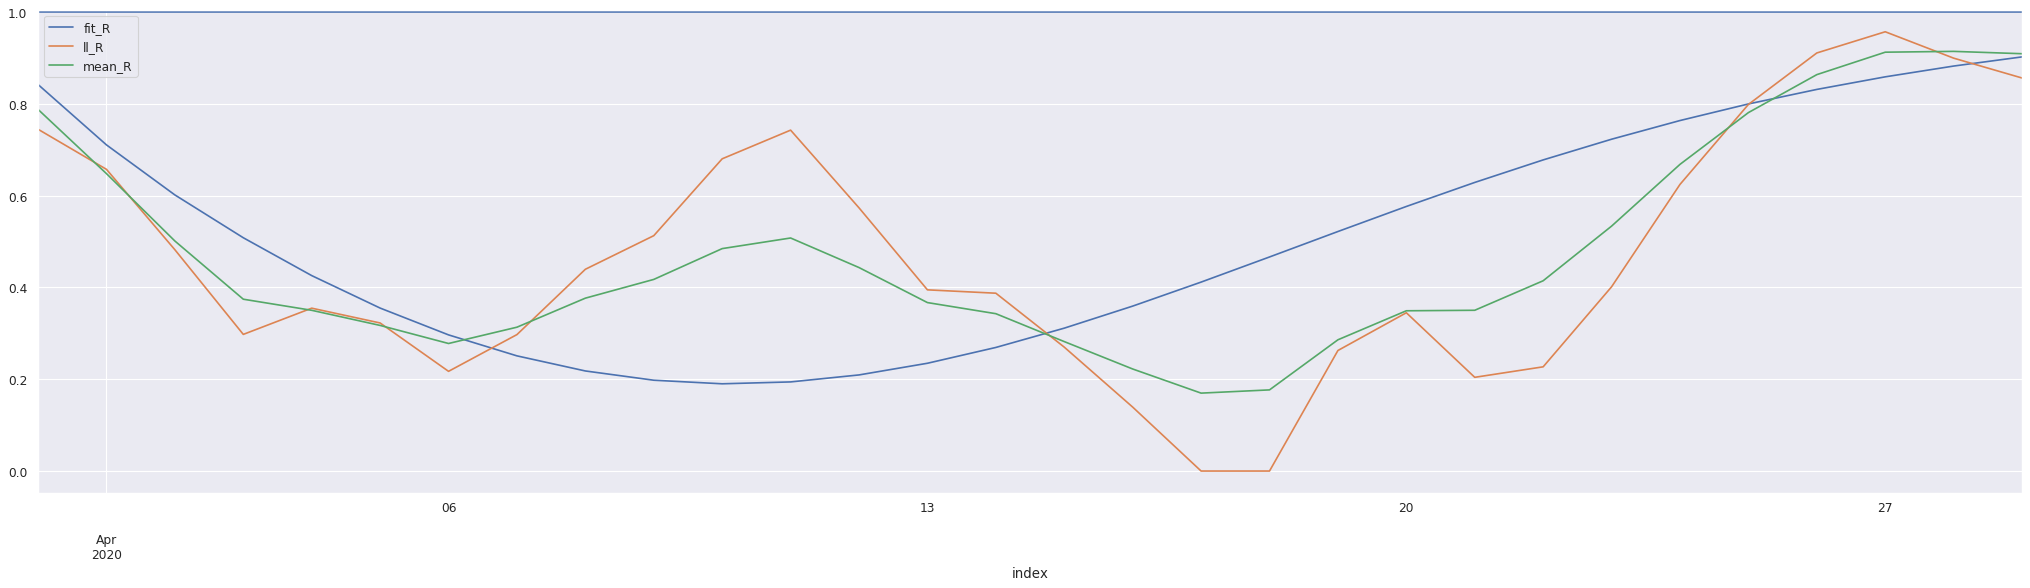

In [23]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_austria.plot_R(ax=ax) # , plot_start_date='2020-03-10'

[COVID-19-Pandemie#Dänemark](https://de.wikipedia.org/wiki/COVID-19-Pandemie#D%C3%A4nemark)

> Dänemark hat besonders früh mit strikten Maßnahmen auf die Corona-Krise reagiert, unter anderem sind seit dem 14. März die Grenzen für Ausländer ohne triftigen Einreisegrund geschlossen.

`2020-03-14`

In [24]:
cbr_denmark = covid19.CasesByRegion('Denmark')
cbr_denmark.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-27,8896,6148,427,123,154,5
2020-04-28,9049,6313,434,153,165,7
2020-04-29,9206,6558,443,157,245,9
2020-04-30,9356,6741,452,150,183,9
2020-05-01,9509,6924,460,153,183,8


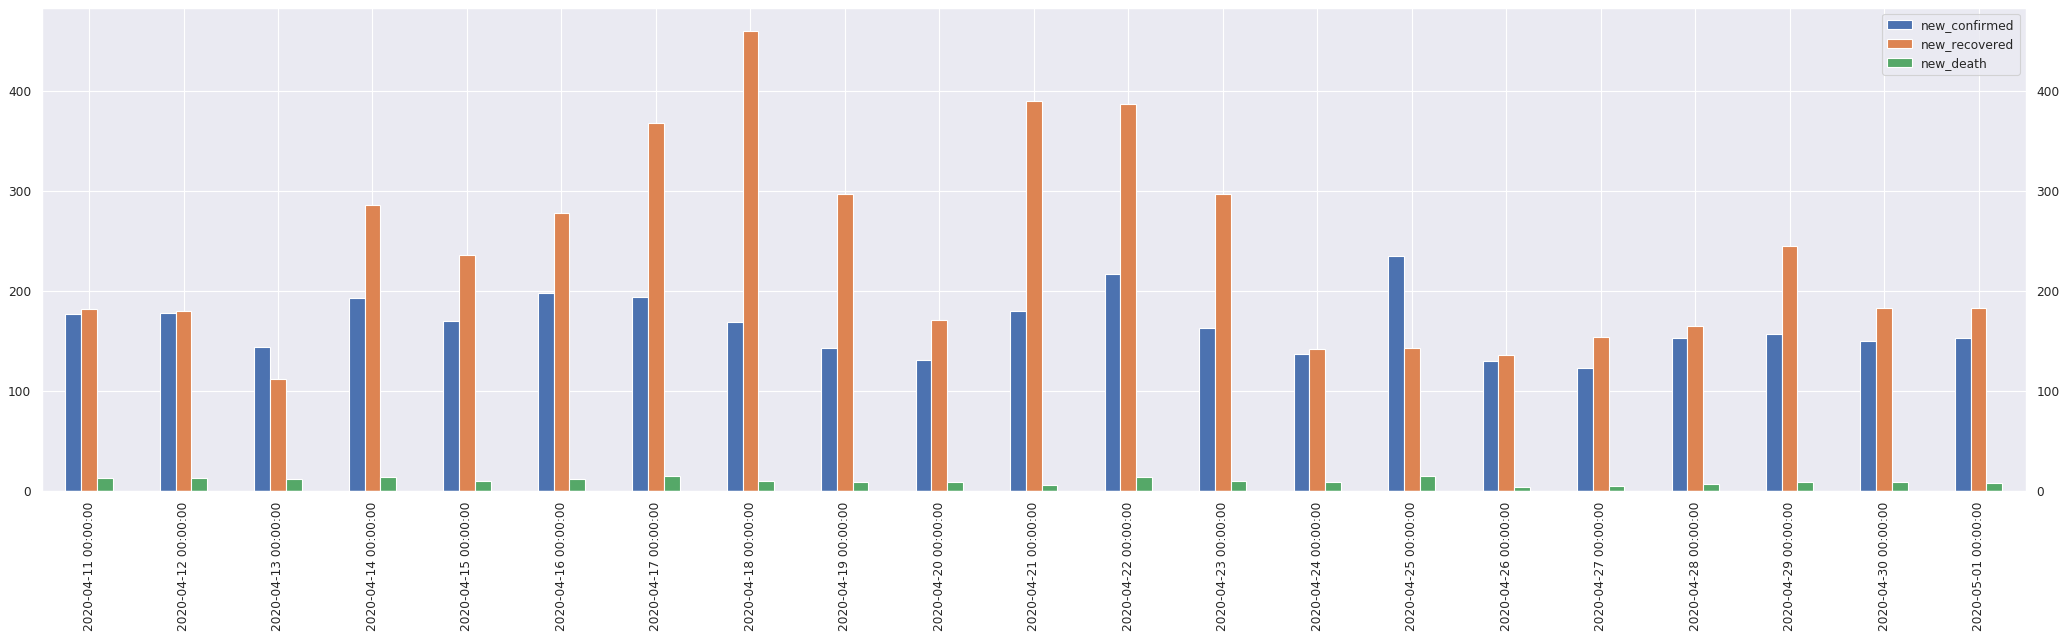

In [25]:
cbr_denmark.plot_daily_stats()

8.0


 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric: seor: 48.10403585089238, max asymptotic: 10070.662722231784; growth-rate: 0.01, date:2020-06-05 00:00:00, projected value: 7.272211906631431


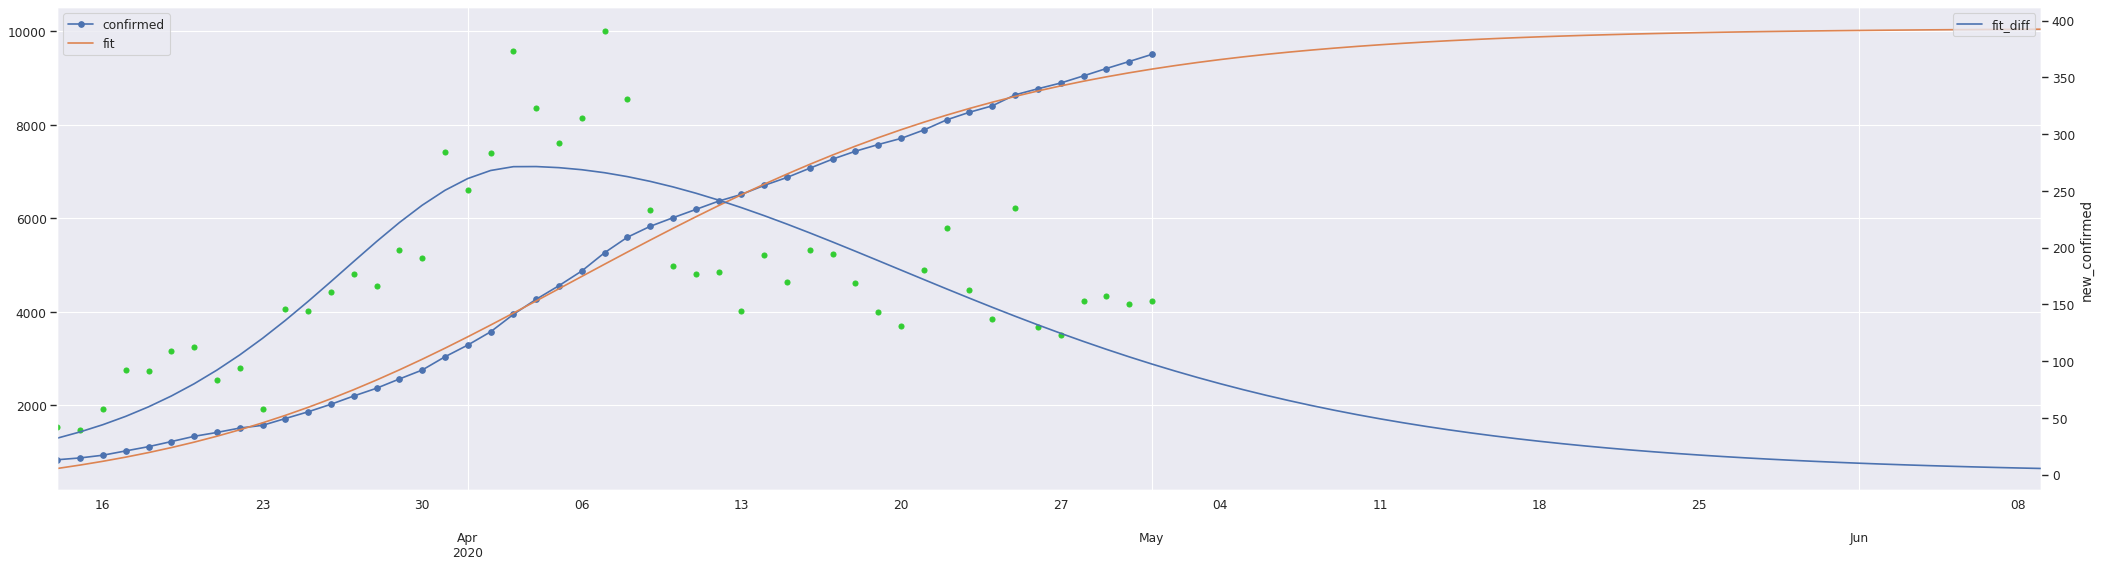

In [26]:
population_denmark  =  5822763.0
percent_denmark     = population_denmark / einwohner_deutschland

denmark_new_confirmed_threshold = (100.0 * percent_denmark) // 1 + 1
print(denmark_new_confirmed_threshold)

# first_date=pd.to_datetime('2020-03-09')
# first_date=pd.to_datetime('2020-03-14')
cbr_denmark.fit(first_date=pd.to_datetime('2020-03-14'), new_confirmed_threshold=denmark_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_denmark.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 14))

In [27]:
cbr_denmark.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,271.334849


In [28]:
cbr_denmark.calculate_R_estimates()
cbr_denmark.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-29,0.62,0.861,0.701,0.849,0.777


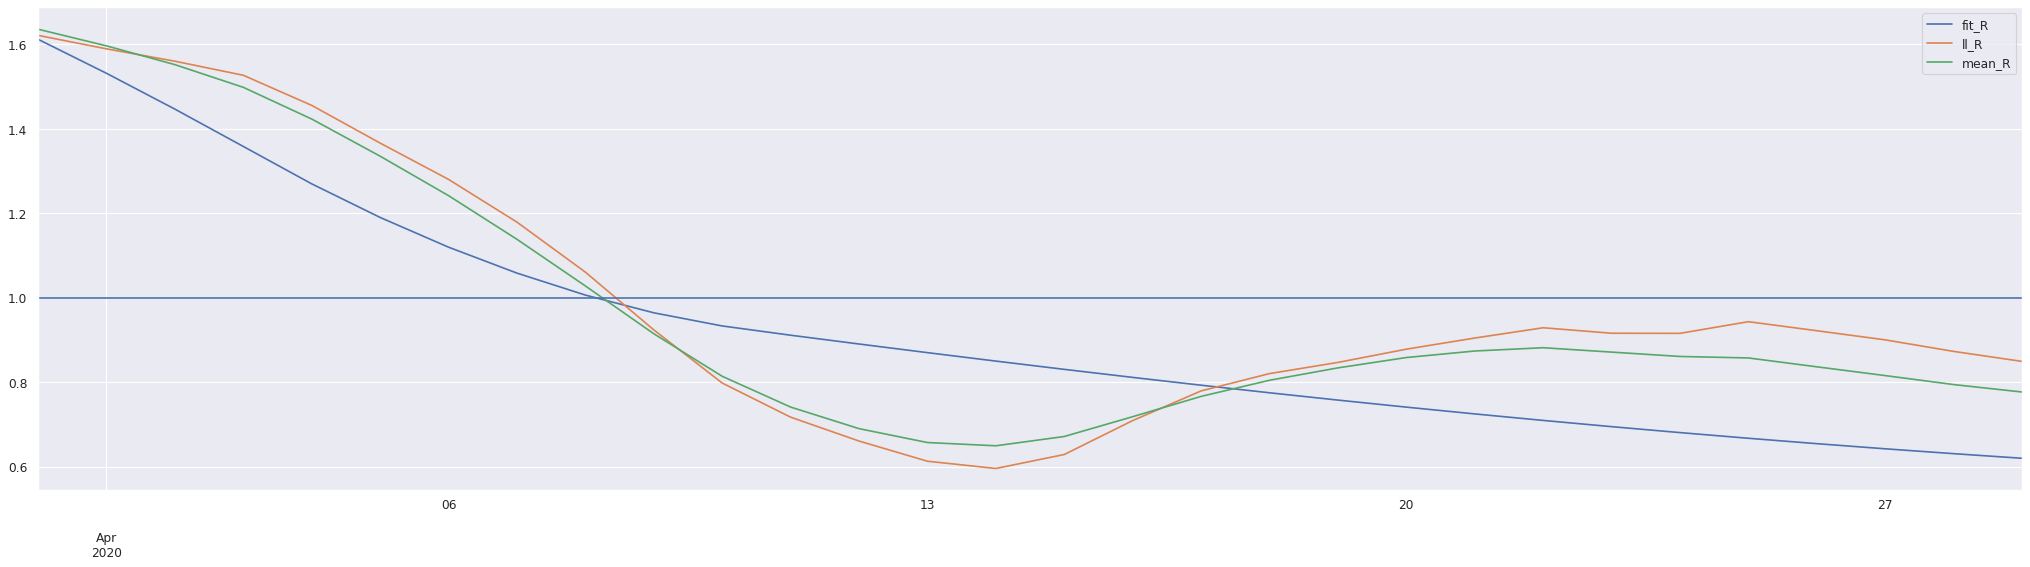

In [29]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_denmark.plot_R(ax=ax) # , plot_start_date='2020-03-10'

There are several data issues since 2020-03-12/2020-03-13 in the input data as pointed out here: [Italy has the same number of cases today as they did yesterday.](https://github.com/CSSEGISandData/COVID-19/issues/599)

Also trying to get the raw numbers that [Coronavirus-Monitor](https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/?fbclid=IwAR04HlqzakGaNssQzbz4d8o8R3gz0C910U8tvfYlBT6P0lVJJvHfk9uS2rc) is using for Germany from [@datentaeterin](https://twitter.com/datentaeterin/status/1237807179815686144). These numbers seem to be more up-to-date than all the other data-sources.

In [30]:
df = covid19.get_italy_df()
cbr_italy = covid19.CasesByRegion('Italy', df=df)
cbr_italy.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-04-28,201505,68941,27359,2091,2317,382
2020-04-29,203591,71252,27682,2086,2311,323
2020-04-30,205463,75945,27967,1872,4693,285
2020-05-01,207428,78249,28236,1965,2304,269
2020-05-02,209328,79914,28710,1900,1665,474


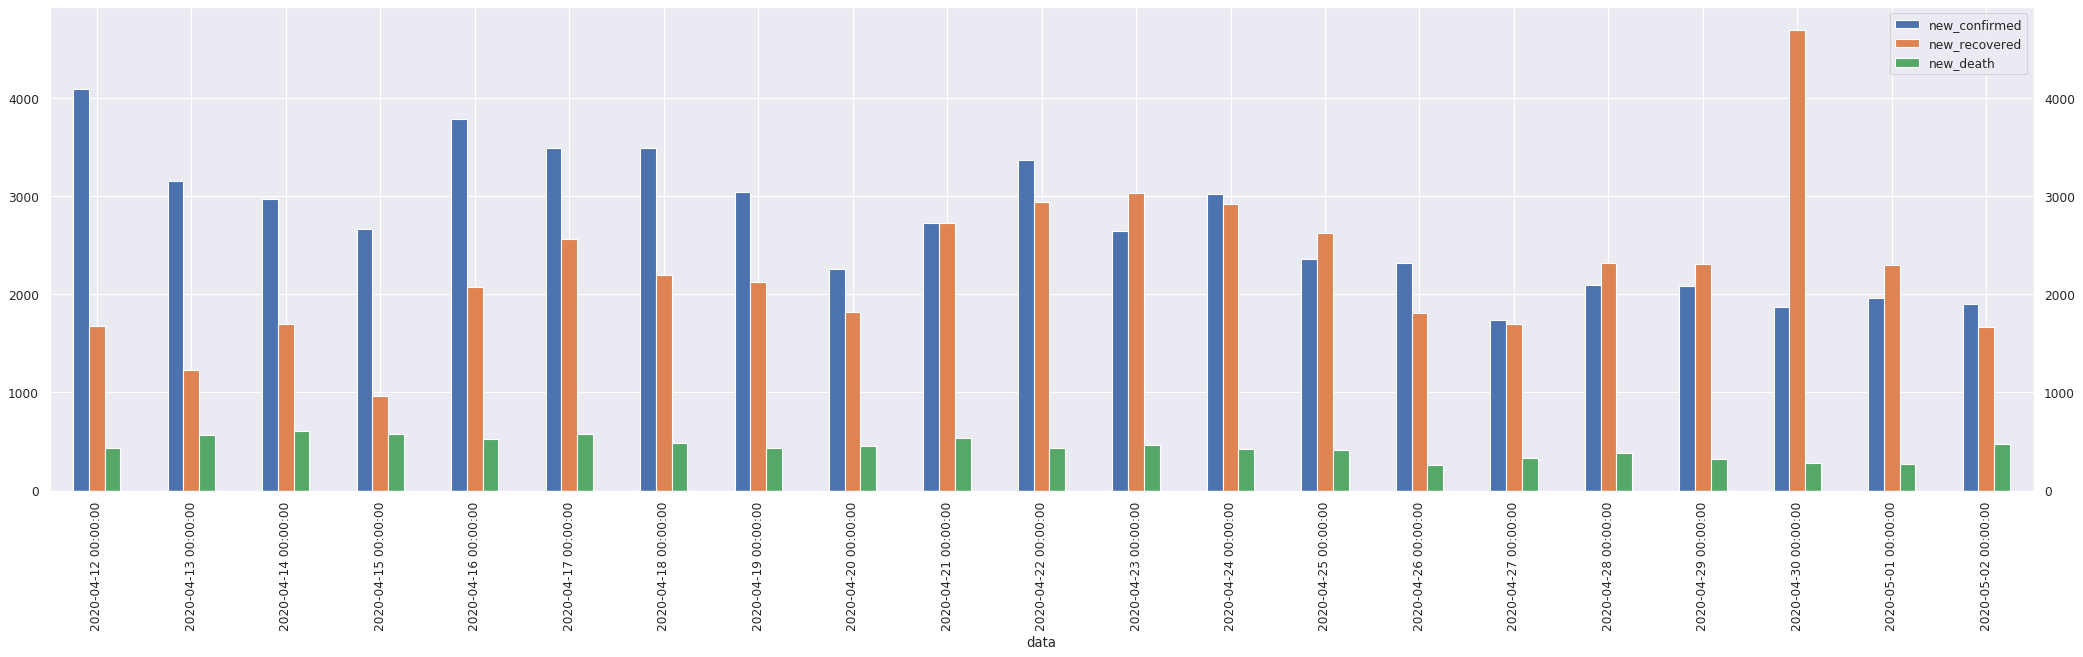

In [31]:
cbr_italy.plot_daily_stats()

In [32]:
cbr_italy.fit(first_date=pd.to_datetime('2020-02-21'))

sigmoid+asymmetric+linear: seor: 489.6146048269578; growth-rate: 0.012, date:2020-06-10 00:00:00, projected value: 1669.062127045458


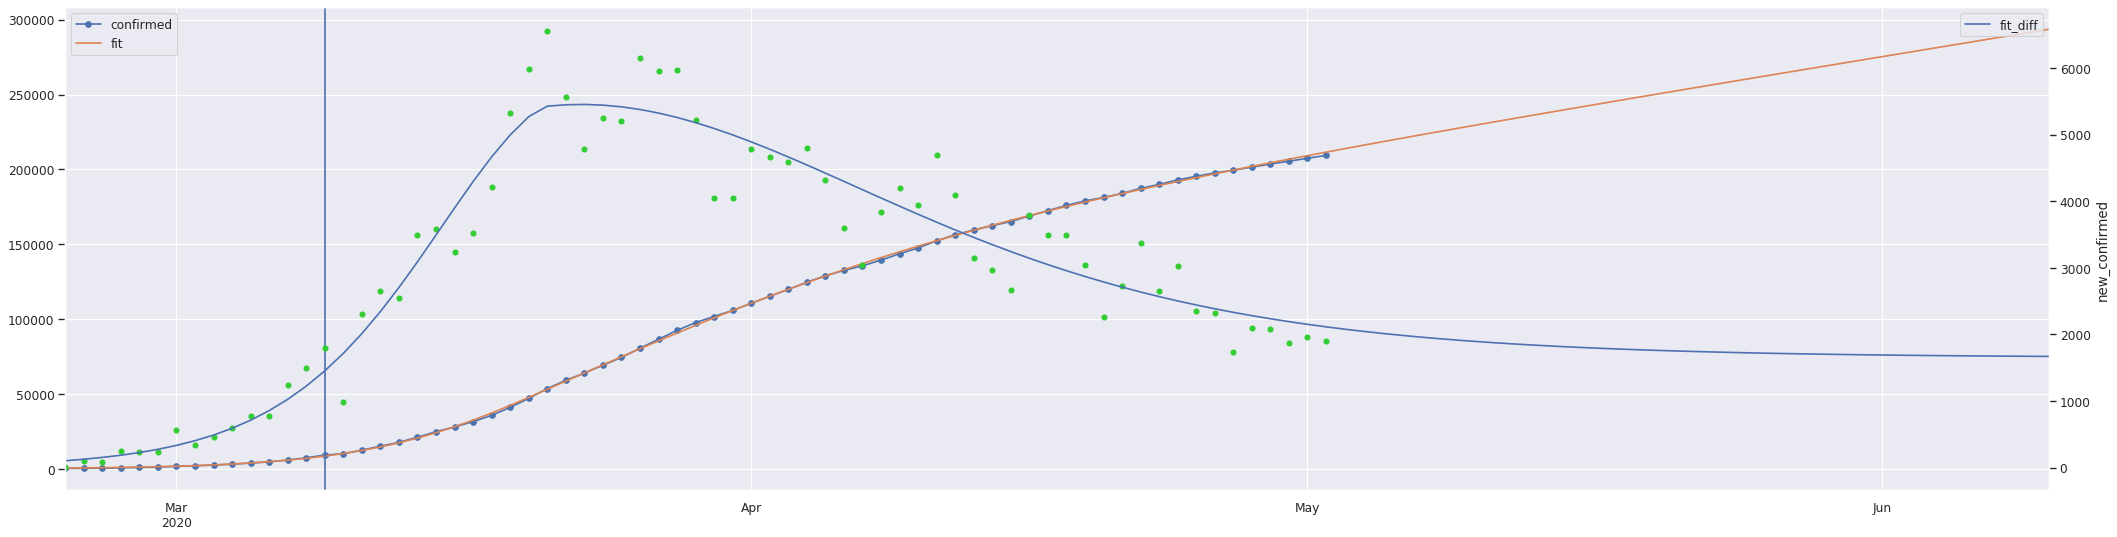

In [33]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_italy.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 9))

In [34]:
cbr_italy.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5454.169414


In [35]:
cbr_italy.calculate_R_estimates()
cbr_italy.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
data,,,,,
2020-04-30,0.843,0.645,0.63,0.651,0.713


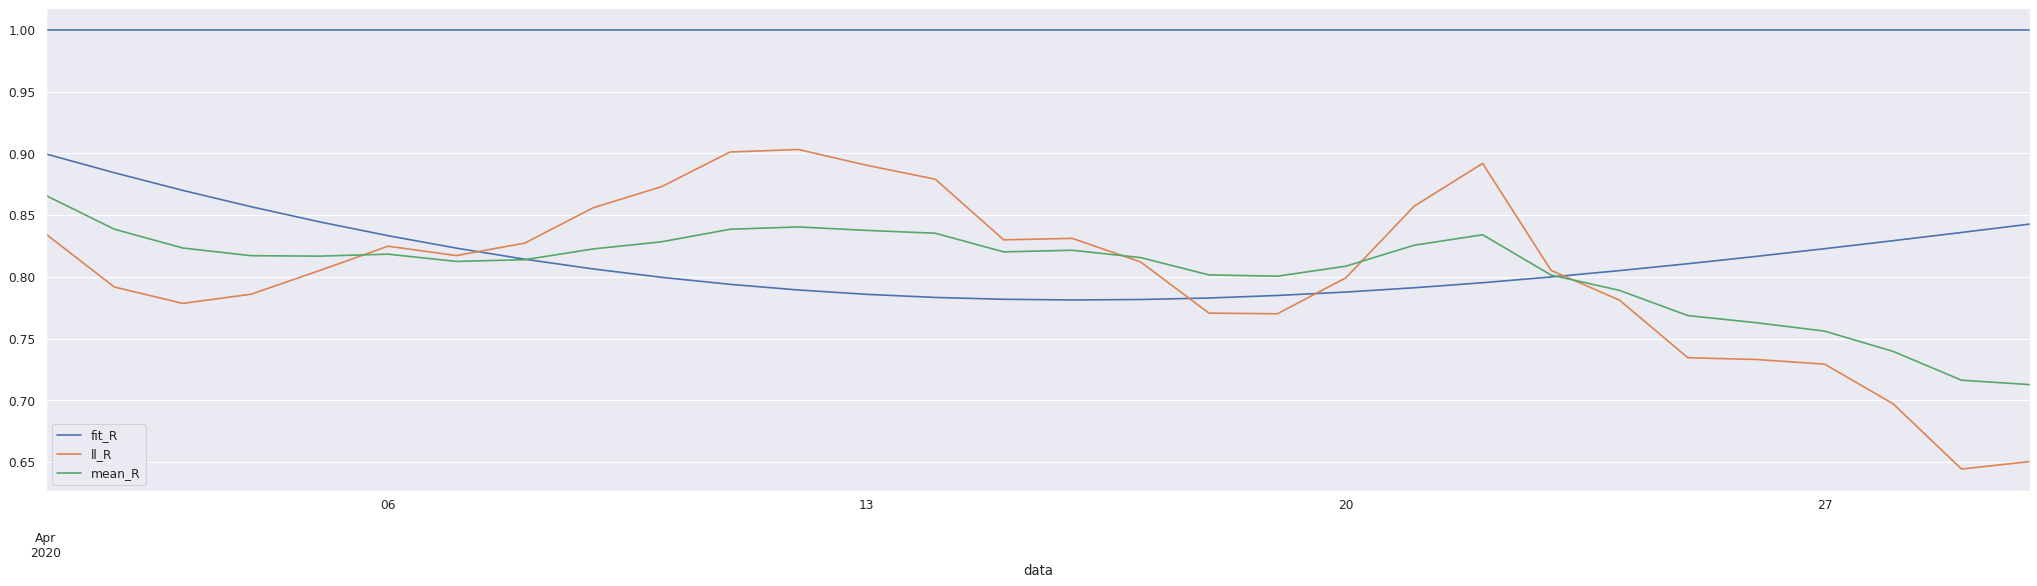

In [36]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_italy.plot_R(ax=ax) # , plot_start_date='2020-03-10'

* [Community Wiki: Resources on Data Science (and friends) vs. COVID-19](https://discourse.data-against-covid.org/t/community-wiki-resources-on-data-science-and-friends-vs-covid-19/731)
* [Number of deaths per age group per country?](https://discourse.data-against-covid.org/t/number-of-deaths-per-age-group-per-country/940)


* [mscbs.gob.es](https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/situacionActual.htm)
* https://covid19.isciii.es/
* [github/datadista](https://github.com/datadista/datasets/tree/master/COVID%2019)

In [37]:
df = covid19.get_spain_df()
cbr_spain = covid19.CasesByRegion('Spain', df=df)
cbr_spain.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-27,230705,100875,23521,2604,2143,331
2020-04-28,233549,102548,23822,2844,1673,301
2020-04-29,236872,108947,24275,3323,6399,453
2020-04-30,240007,112050,24543,3135,3103,268
2020-05-01,243198,114678,24824,3191,2628,281


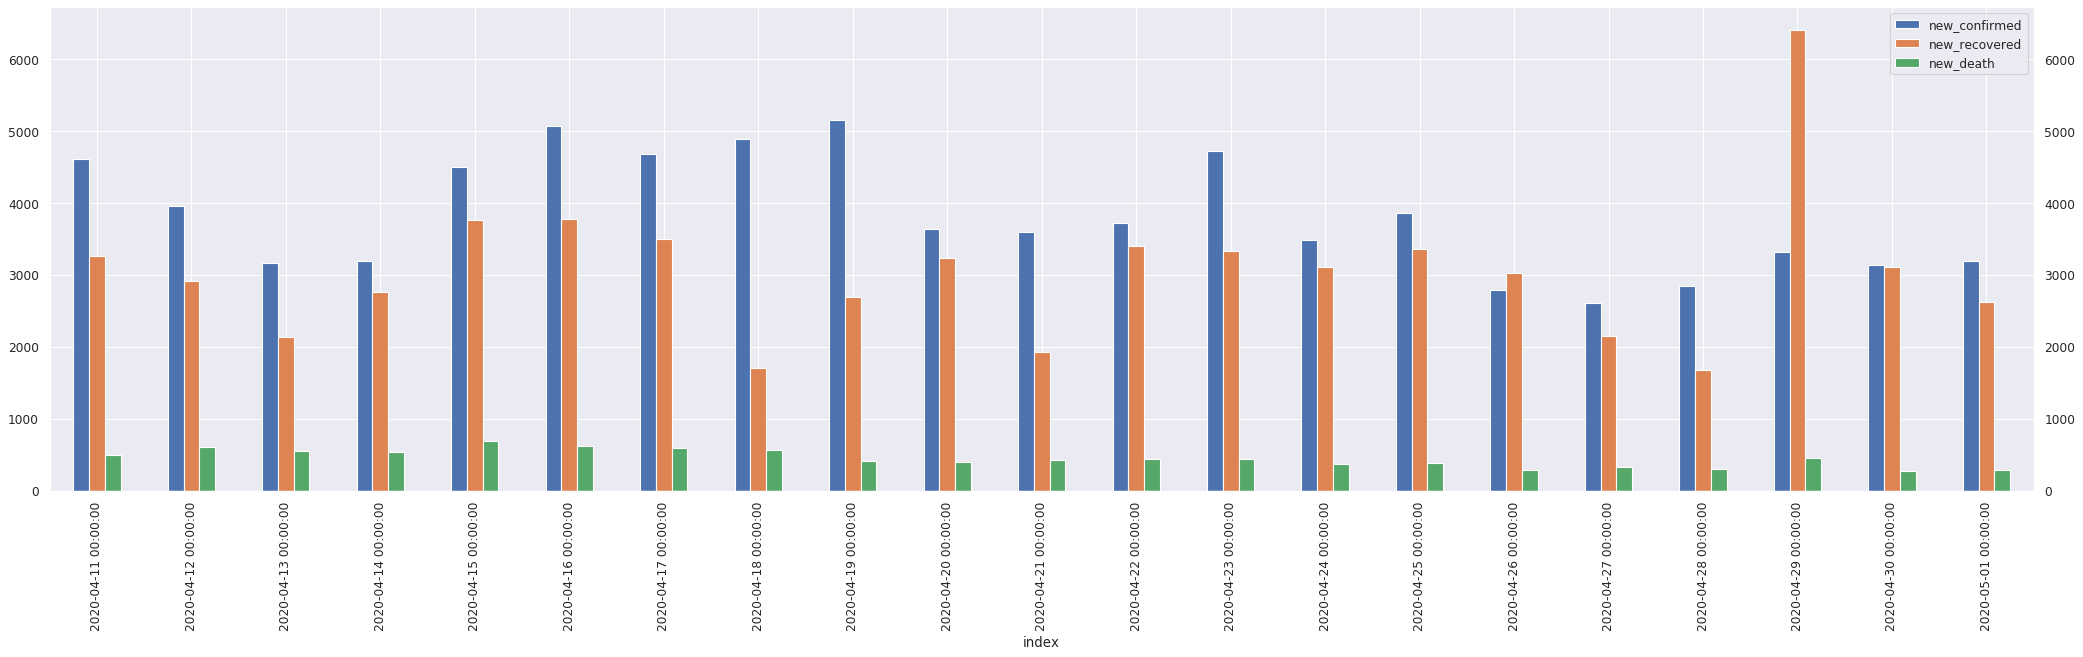

In [38]:
cbr_spain.plot_daily_stats()

In [39]:
cbr_spain.fit(first_date=pd.to_datetime('2020-03-04'))

sigmoid+asymmetric+linear: seor: 790.8636543375346; growth-rate: 0.016, date:2020-06-09 00:00:00, projected value: 3569.639049145021


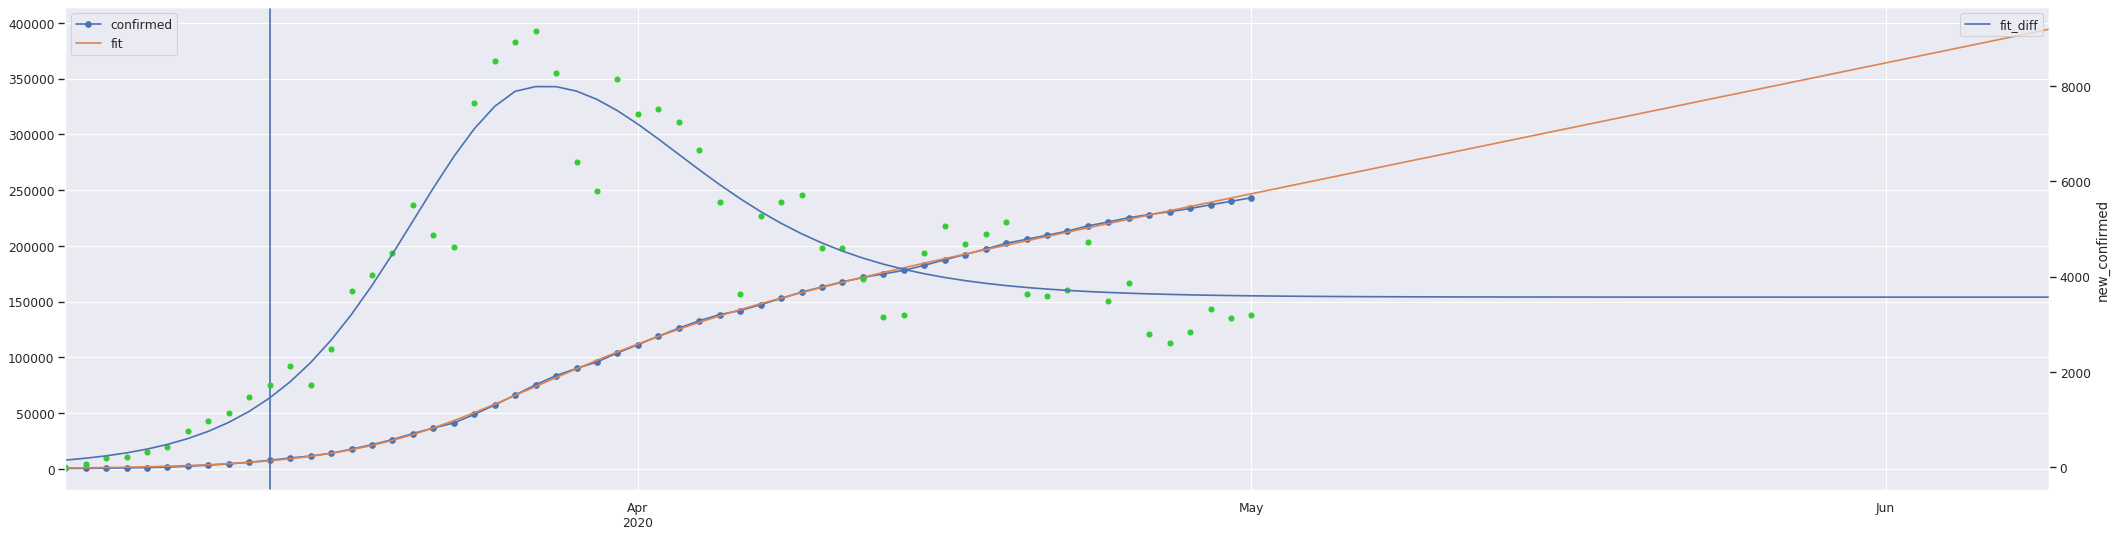

In [40]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_spain.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 14))

In [41]:
cbr_spain.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,7986.105983


In [42]:
cbr_spain.calculate_R_estimates()
cbr_spain.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-04-29,0.972,0.843,0.878,0.86,0.892


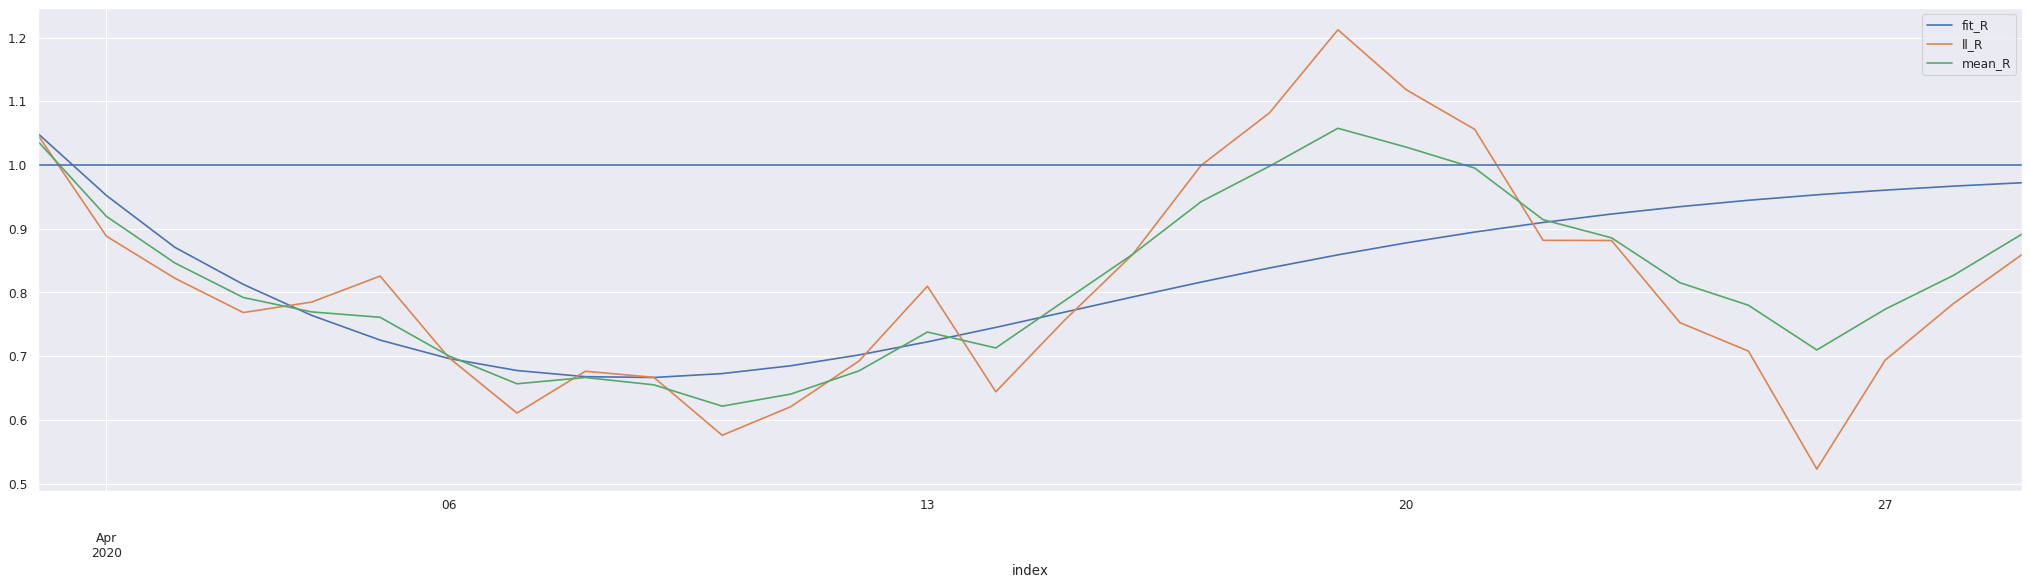

In [43]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_spain.plot_R(ax=ax) # , plot_start_date='2020-03-10'

* [Community Wiki: Resources on Data Science (and friends) vs. COVID-19](https://discourse.data-against-covid.org/t/community-wiki-resources-on-data-science-and-friends-vs-covid-19/731)
* [Number of deaths per age group per country?](https://discourse.data-against-covid.org/t/number-of-deaths-per-age-group-per-country/940)



* [opencovid19-fr / data](https://github.com/opencovid19-fr/data/blob/master/README.en.md)
    * [chiffres-cles.csv](https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv)
    * [dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/5e09dff7cb434fb194e22261689e2887)
    * [santepubliquefrance](https://www.santepubliquefrance.fr/maladies-et-traumatismes/maladies-et-infections-respiratoires/infection-a-coronavirus/articles/infection-au-nouveau-coronavirus-sars-cov-2-covid-19-france-et-monde)

In [44]:
df =covid19.get_france_df()
cbr_france = covid19.CasesByRegion('France', df=df)
cbr_france.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
date,,,,,,
2020-04-27,128339,45513,23293,3764,610,437
2020-04-28,129859,46886,23660,1520,1373,367
2020-04-29,128442,48228,24087,-1417,1342,427
2020-04-30,129581,49476,24376,1139,1248,289
2020-05-01,130185,50212,24594,604,736,218


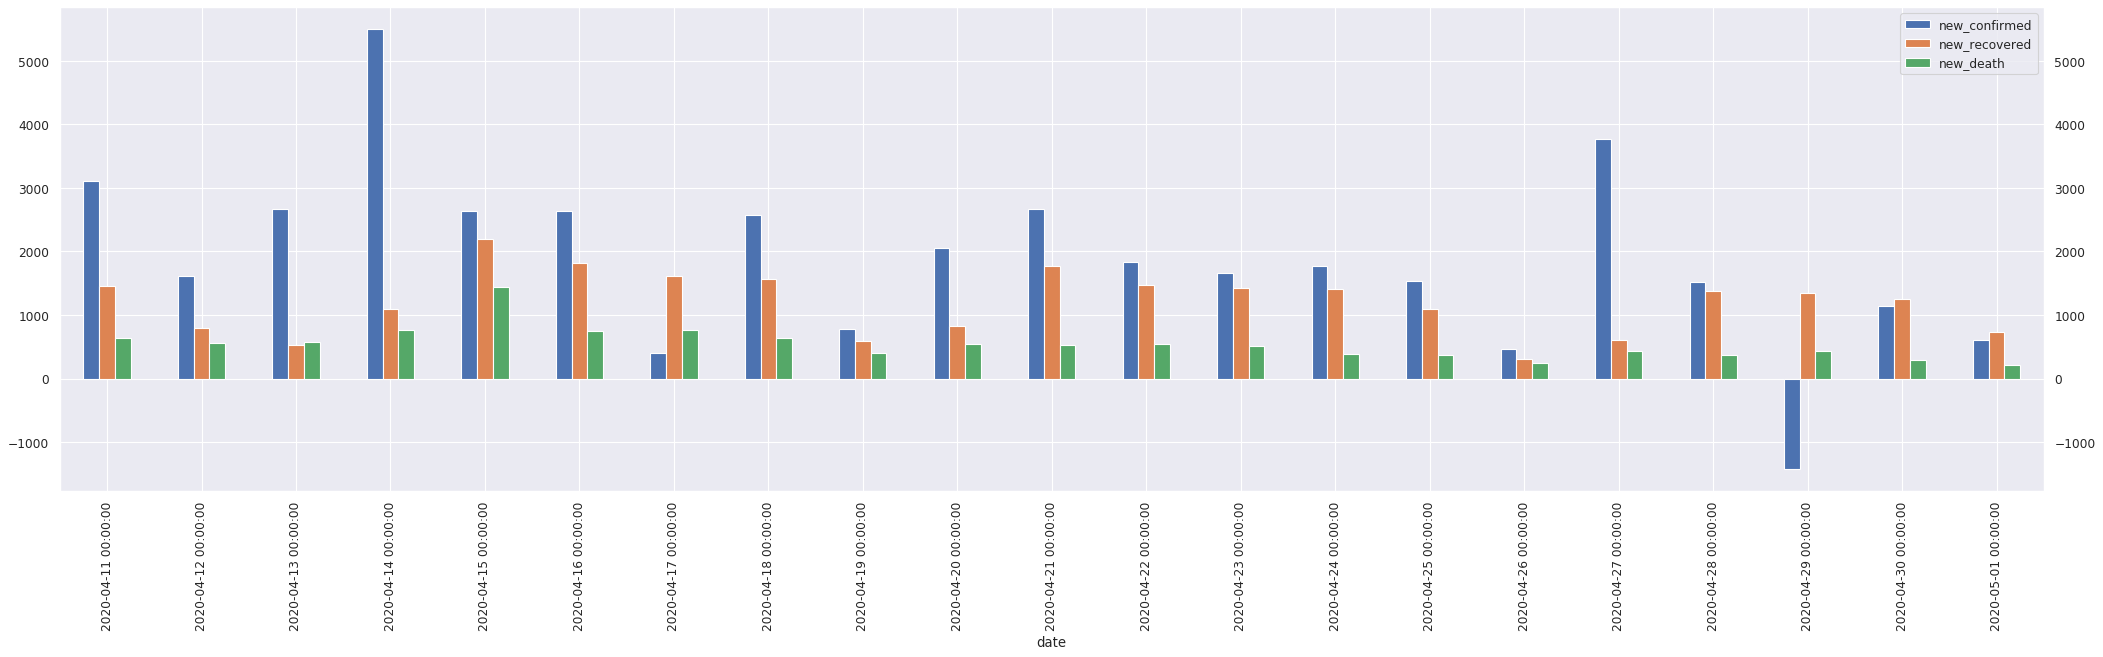

In [45]:
cbr_france.plot_daily_stats()

In [46]:
cbr_france.fit(first_date=pd.to_datetime('2020-03-04'))

sigmoid+asymmetric: seor: 1078.1433383568733, max asymptotic: 141319.6077981171; growth-rate: 0.008, date:2020-05-25 00:00:00, projected value: 89.43588582270627


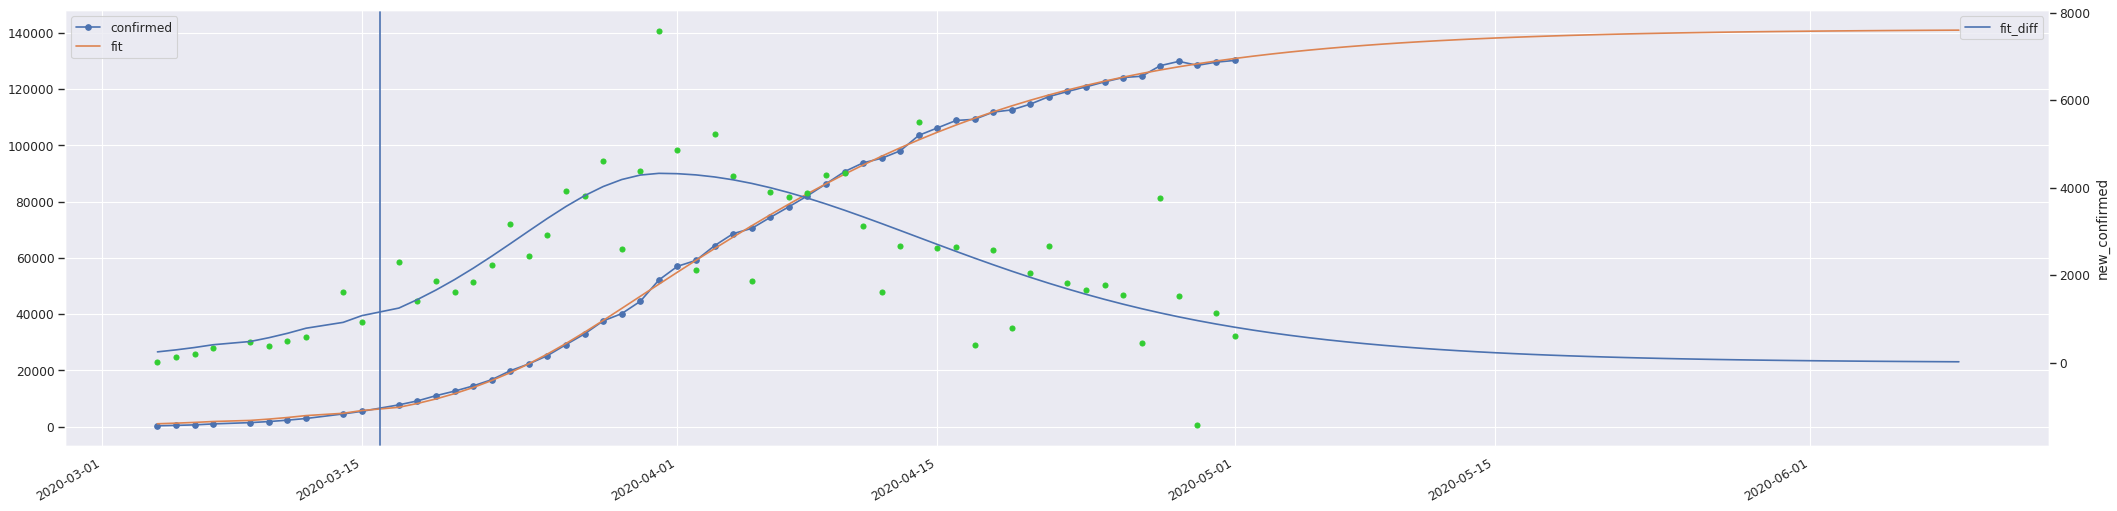

In [47]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_france.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 16))

In [48]:
cbr_france.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,4329.011416


In [49]:
cbr_france.calculate_R_estimates()
cbr_france.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
date,,,,,
2020-04-29,0.464,0.505,0.0,0.525,0.498


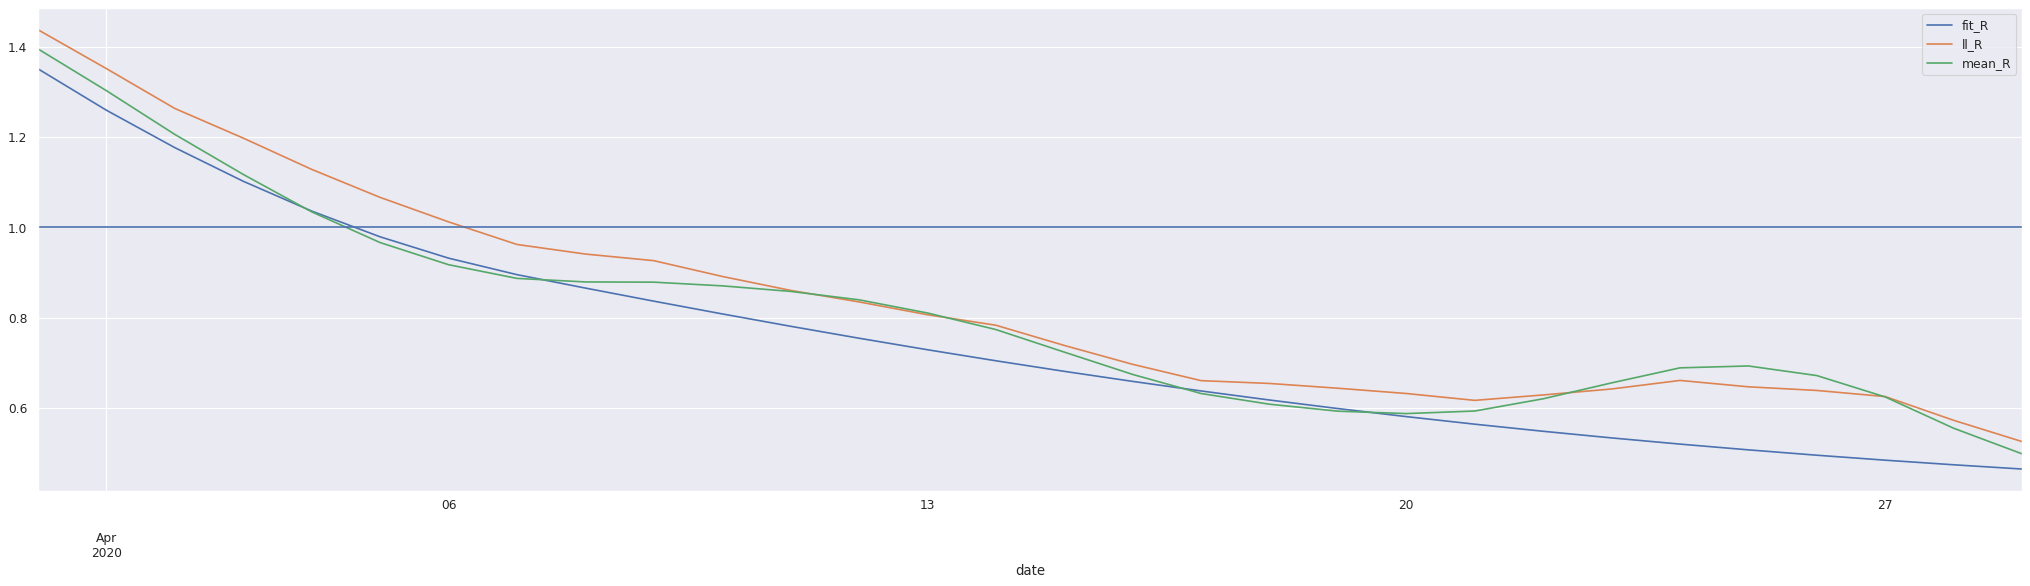

In [50]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_france.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [51]:
cbr_south_korea = covid19.CasesByRegion('Korea, South')
cbr_south_korea.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-27,10752,8854,244,14,90,1
2020-04-28,10761,8922,246,9,68,2
2020-04-29,10765,9059,247,4,137,1
2020-04-30,10774,9072,248,9,13,1
2020-05-01,10780,9123,250,6,51,2


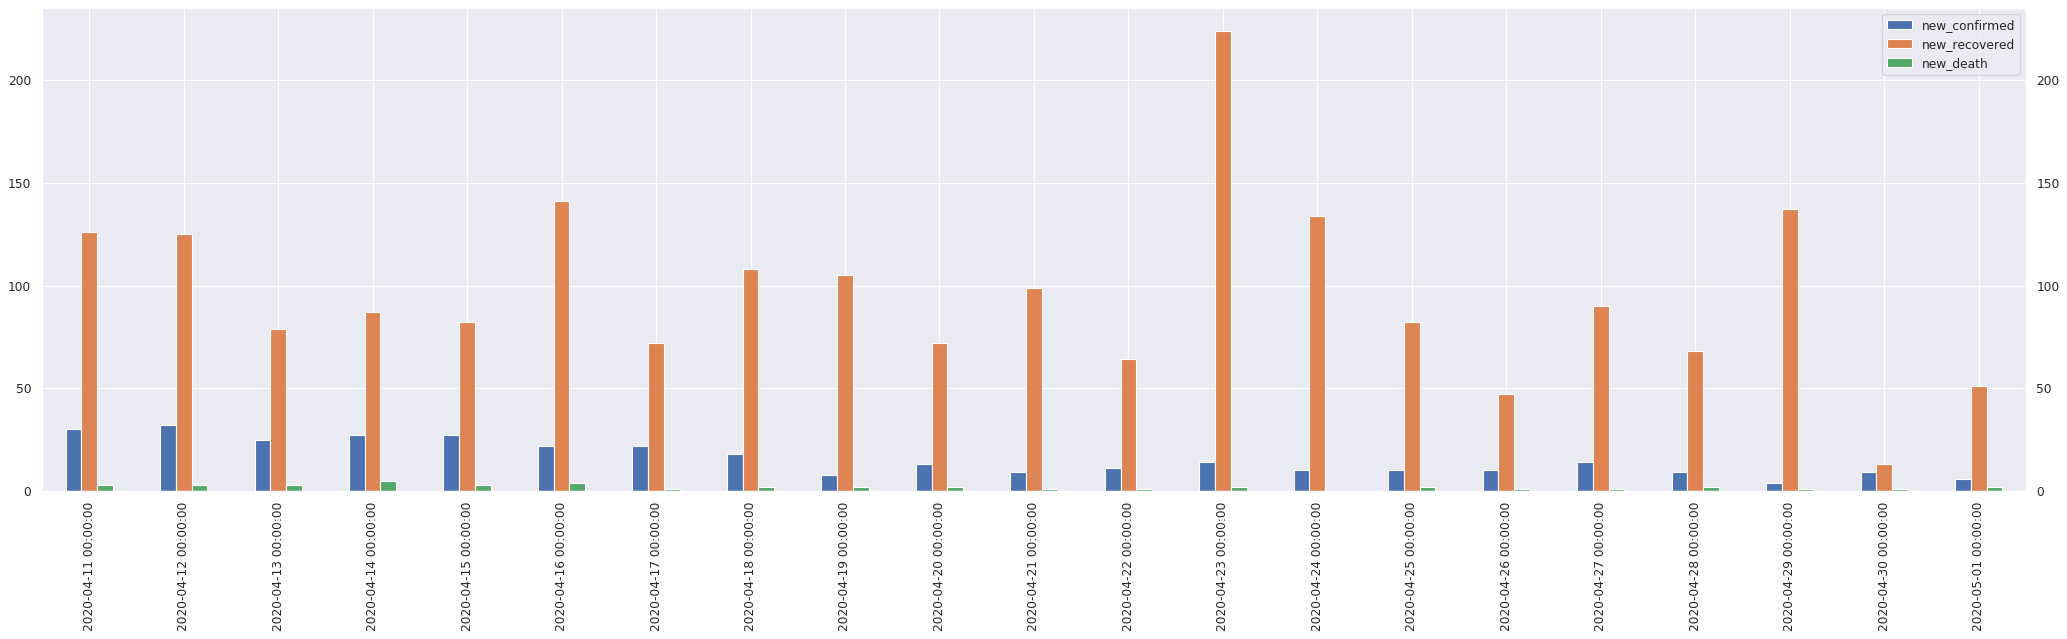

In [52]:
cbr_south_korea.plot_daily_stats()

In [53]:
cbr_uk = covid19.CasesByRegion('United Kingdom')
cbr_uk.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-27,158348,807,24458,4311,29,341
2020-04-28,162350,813,25369,4002,6,911
2020-04-29,166441,857,26166,4091,44,797
2020-04-30,172481,859,26842,6040,2,676
2020-05-01,178685,892,27583,6204,33,741


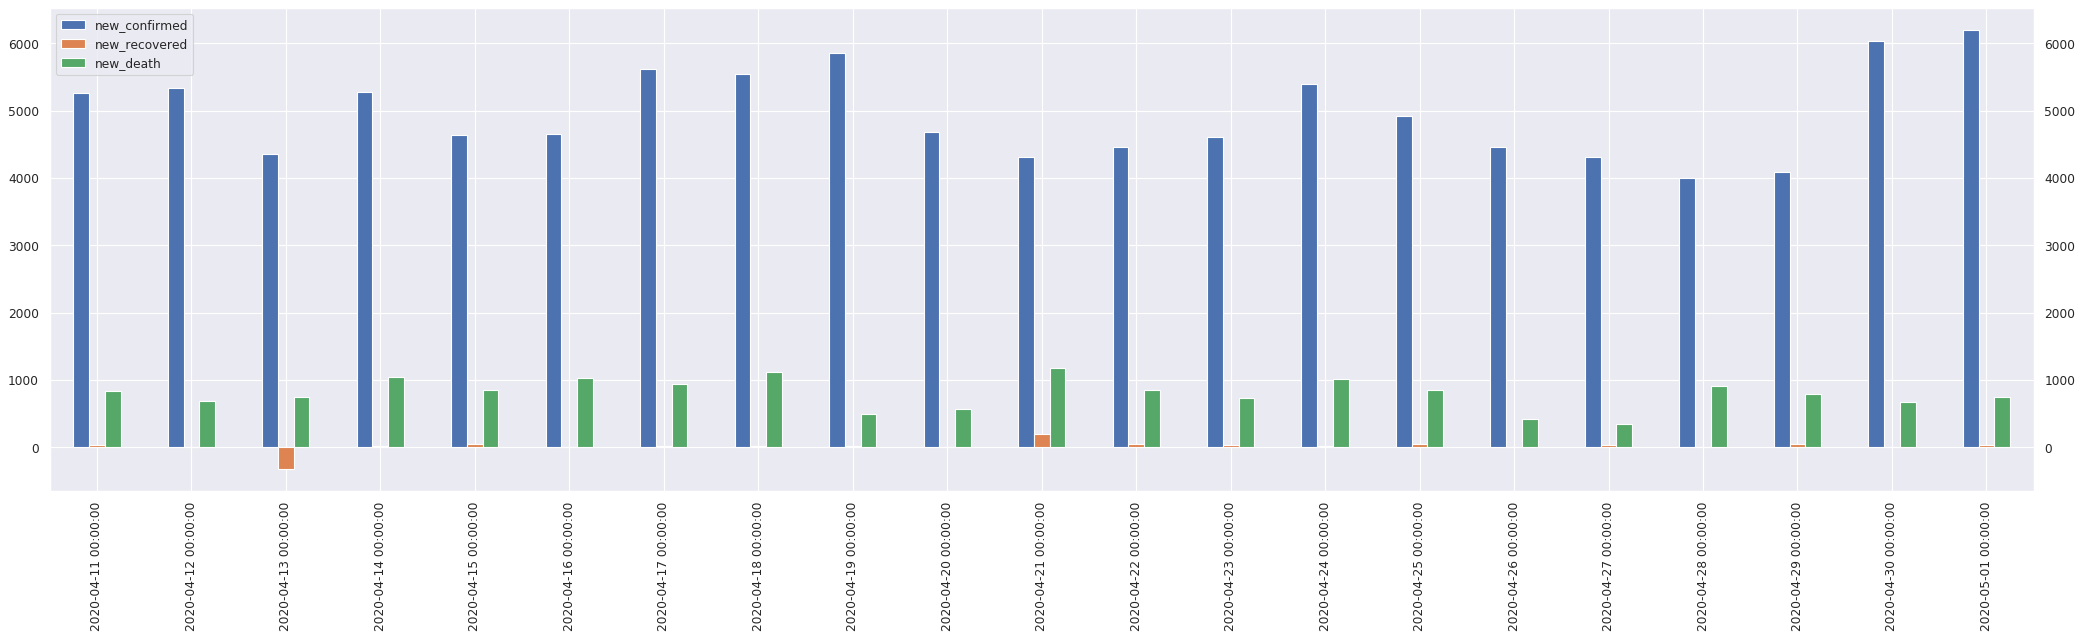

In [54]:
cbr_uk.plot_daily_stats()

In [55]:
cbr_uk.fit(first_date=pd.to_datetime('2020-03-05'))

sigmoid+linear: seor: 681.7622584051533, max asymptotic: 56037.213861641525; growth-rate: 0.029, date:2020-06-09 00:00:00, projected value: 4238.856881603676


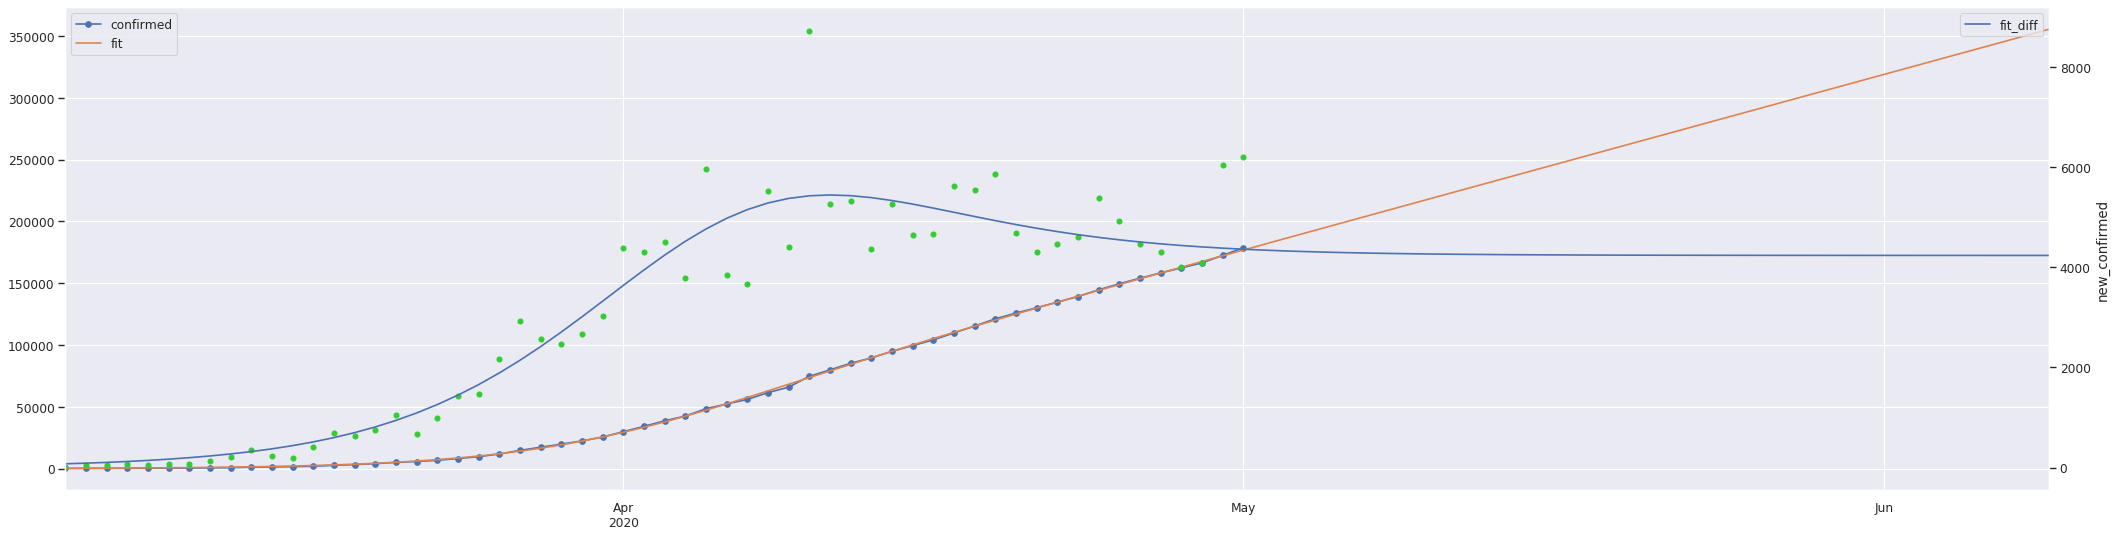

In [56]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_uk.plot_with_fits(ax=ax)

In [57]:
cbr_uk.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5447.22779


In [58]:
cbr_uk.calculate_R_estimates()
cbr_uk.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-29,0.933,0.937,0.912,1.082,0.984


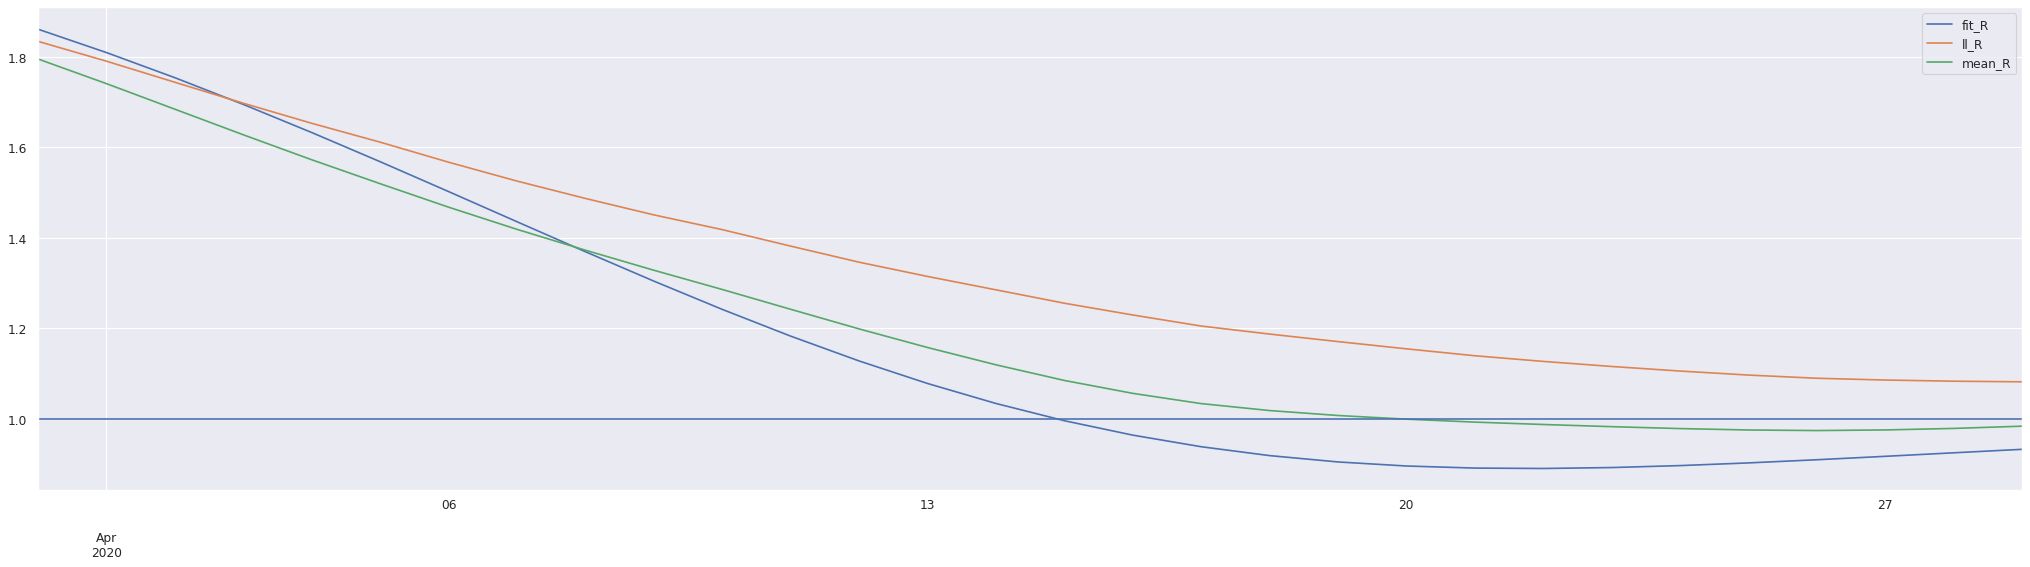

In [59]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_uk.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [60]:
cbr_us = covid19.CasesByRegion('US')
cbr_us.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-27,988197,111424,56259,22412,4436,1378
2020-04-28,1012582,115936,58355,24385,4512,2096
2020-04-29,1039909,120720,60967,27327,4784,2612
2020-04-30,1069424,153947,62996,29515,33227,2029
2020-05-01,1103461,164015,64943,34037,10068,1947


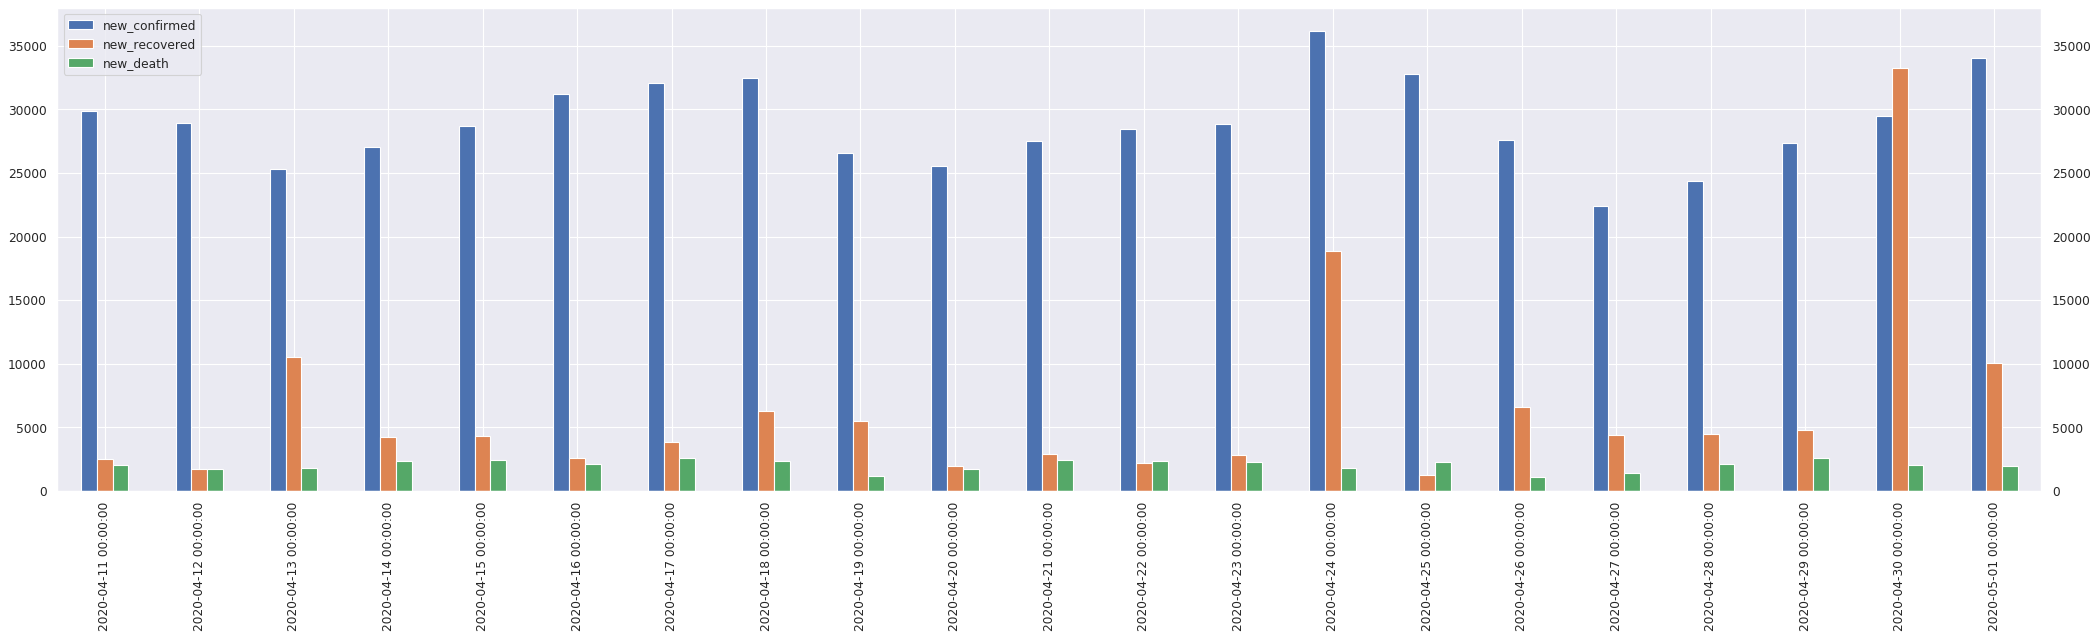

In [61]:
cbr_us.plot_daily_stats()

In [62]:
cbr_us.fit(first_date=pd.to_datetime('2020-03-11'))

sigmoid+asymmetric: seor: 2500.389853919936, max asymptotic: 2794976.0660115145; growth-rate: 0.027, date:2020-06-09 00:00:00, projected value: 12990.278707159992


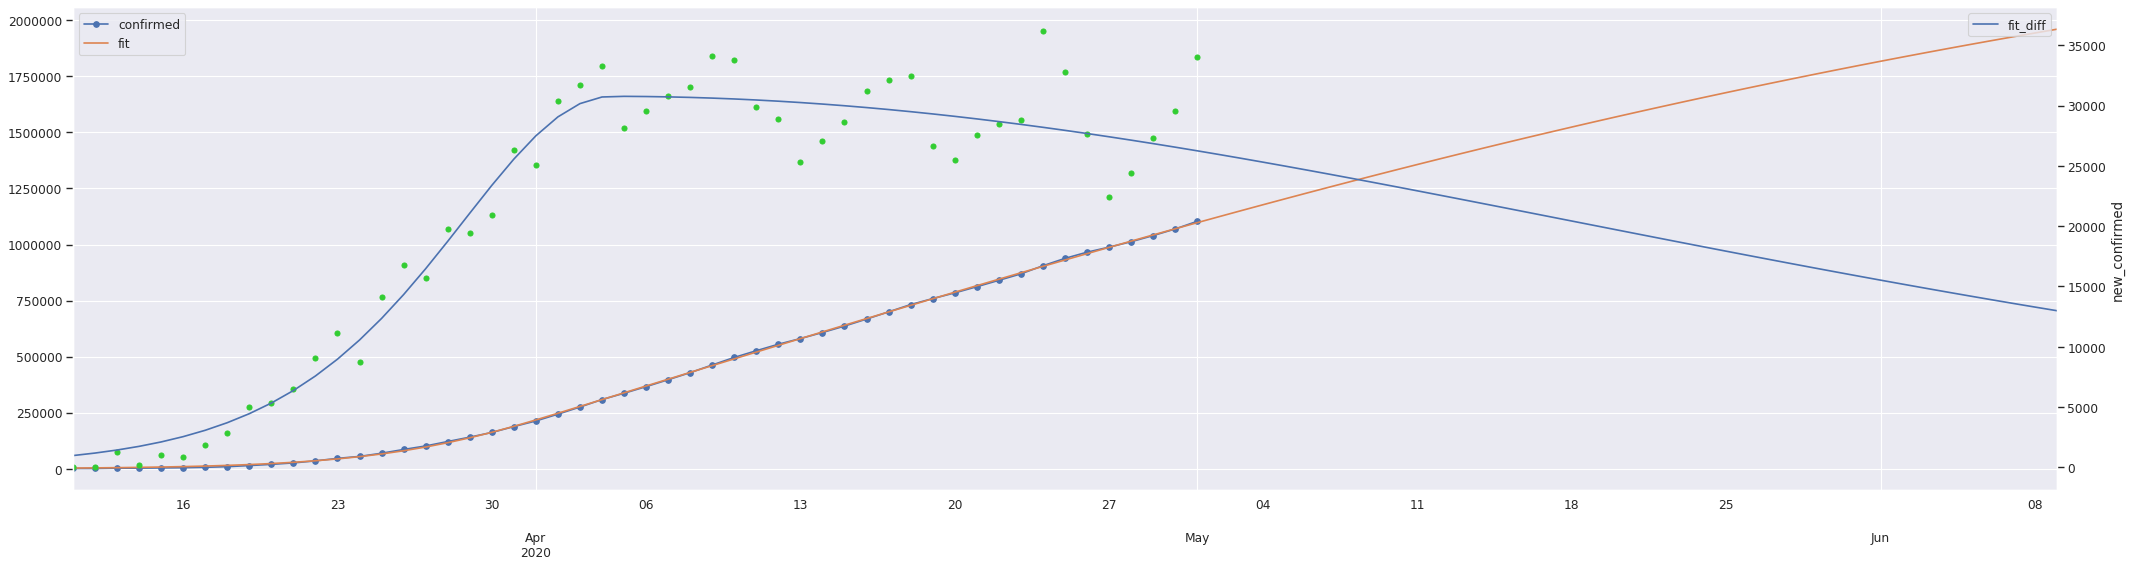

In [63]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_us.plot_with_fits(ax=ax)

In [64]:
cbr_us.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,30770.782827


In [65]:
cbr_us.calculate_R_estimates()
cbr_us.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-29,0.935,0.876,0.933,1.159,0.99


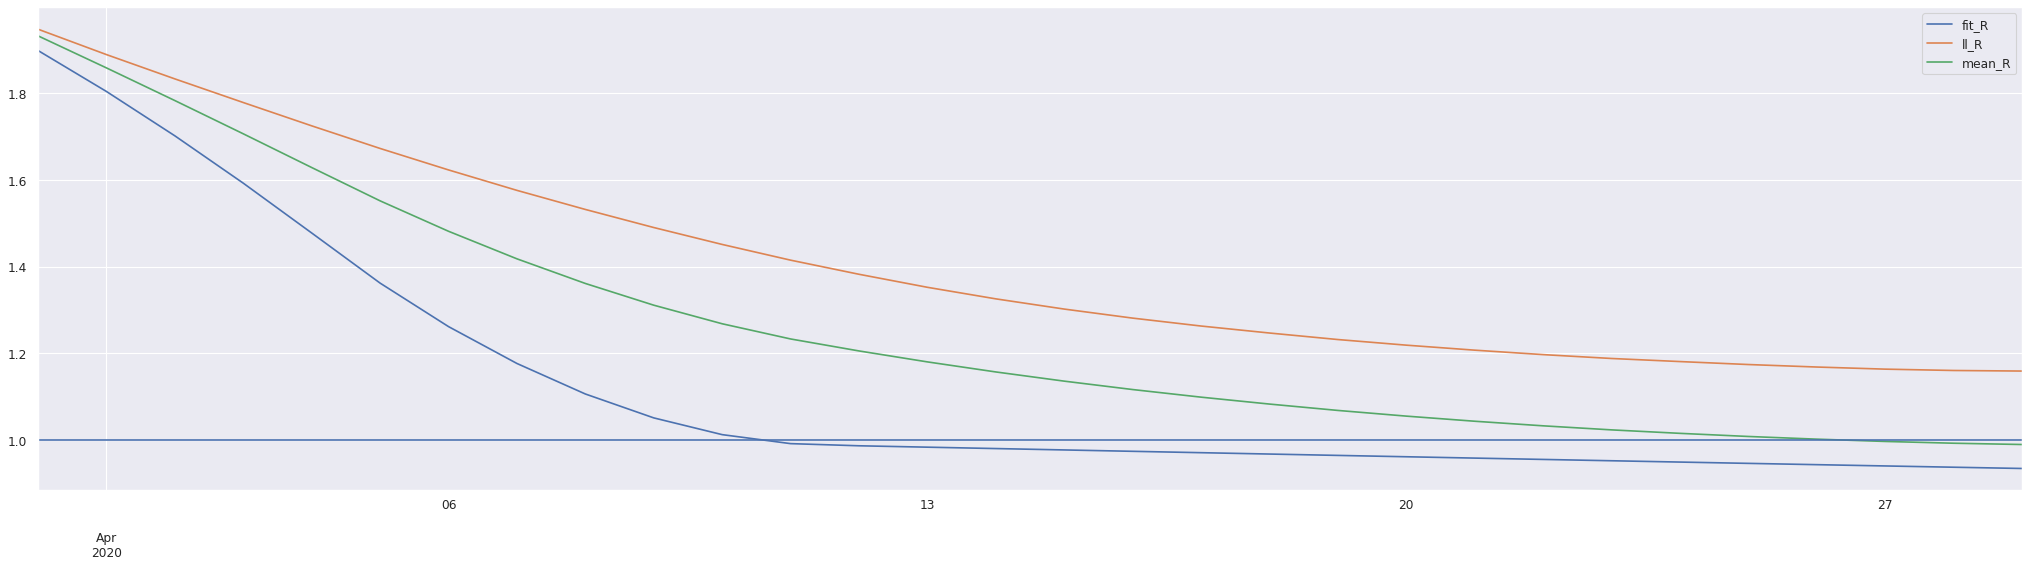

In [66]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_us.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [67]:
cbr_switzerland = covid19.CasesByRegion('Switzerland')
cbr_switzerland.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-27,29164,22200,1665,103,400,55
2020-04-28,29264,22600,1699,100,400,34
2020-04-29,29407,22600,1716,143,0,17
2020-04-30,29586,23400,1737,179,800,21
2020-05-01,29705,23900,1754,119,500,17


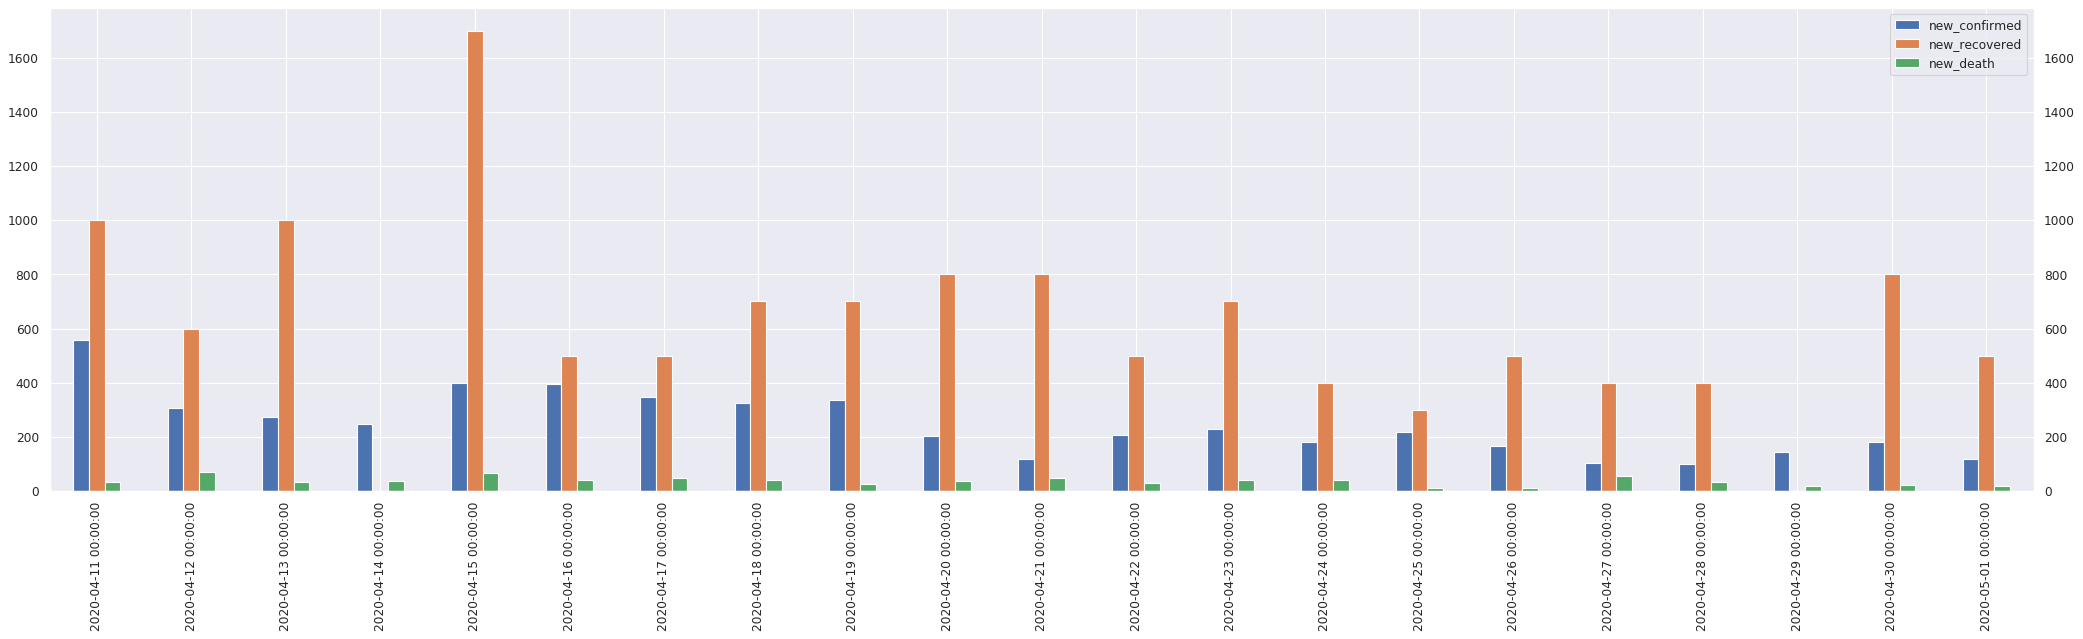

In [68]:
cbr_switzerland.plot_daily_stats()

In [69]:
cbr_switzerland.fit(first_date=pd.to_datetime('2020-03-05'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 173.08136244791137, max asymptotic: 30426.637881623486; growth-rate: 0.004, date:2020-05-02 00:00:00, projected value: 89.66456793920456


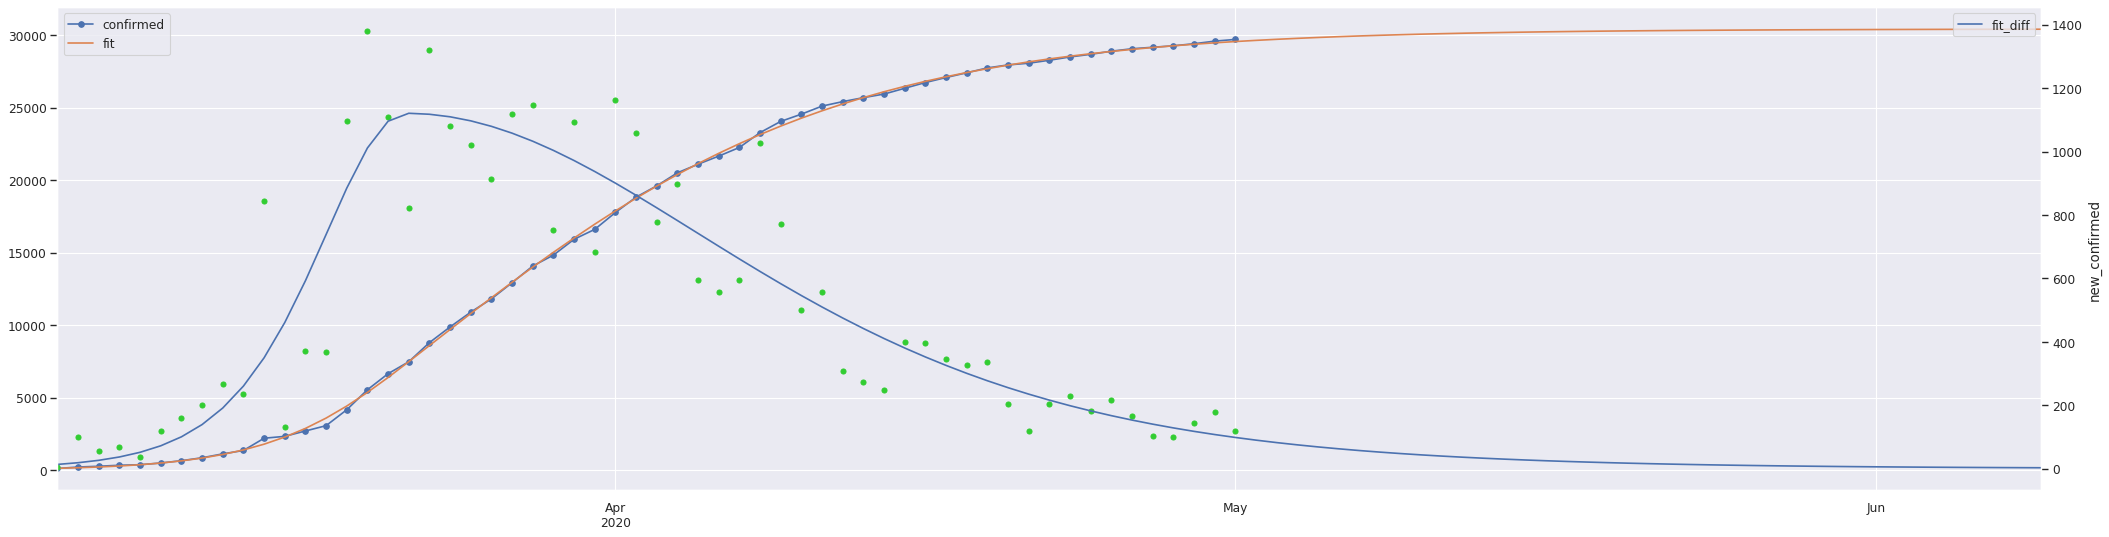

In [70]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_switzerland.plot_with_fits(ax=ax)

In [71]:
cbr_switzerland.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,1120.566669


In [72]:
cbr_switzerland.calculate_R_estimates()
cbr_switzerland.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-29,0.418,0.545,0.682,0.542,0.502


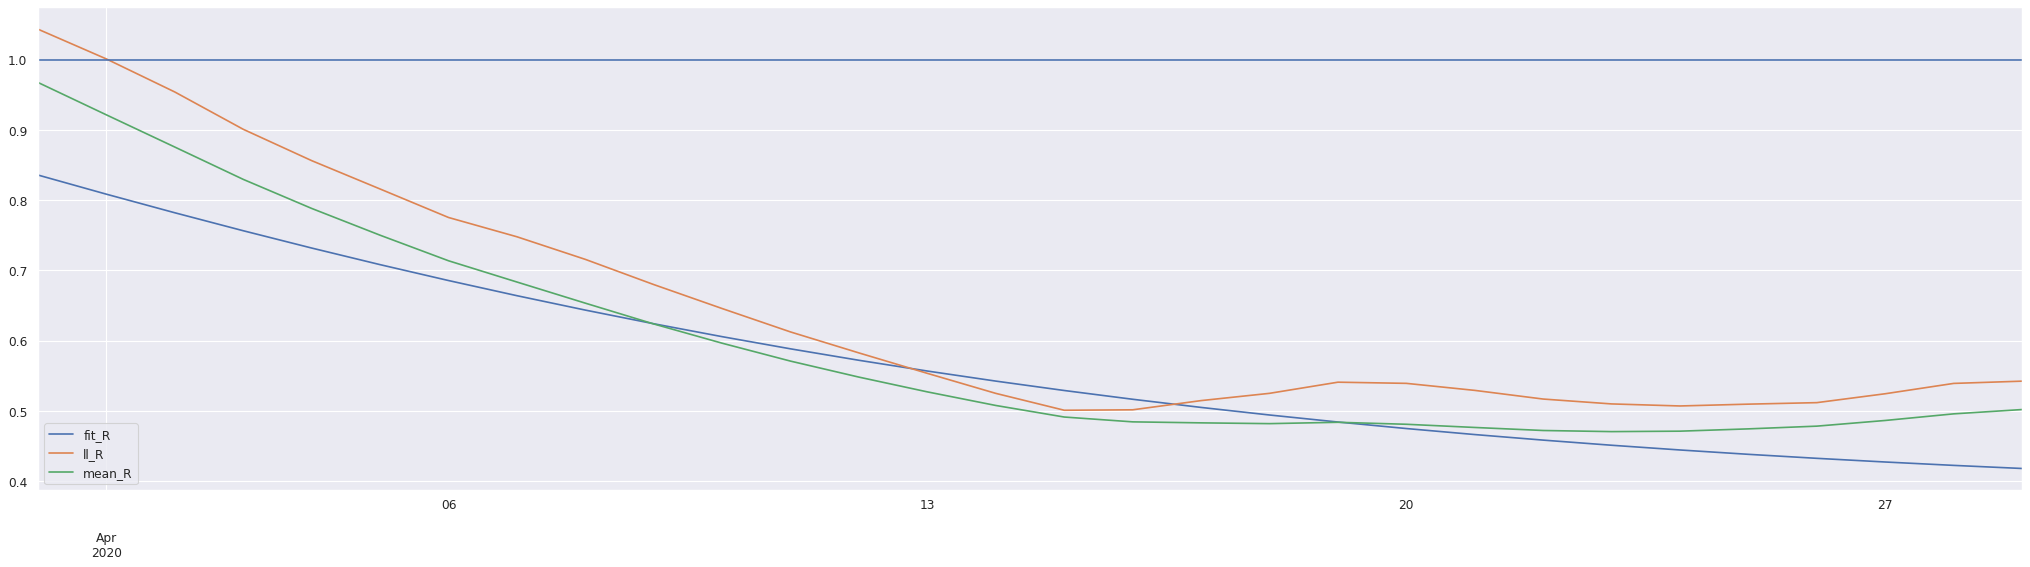

In [73]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_switzerland.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [74]:
cbr_australia = covid19.CasesByRegion('Australia')
cbr_australia.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-27,6721,5588,83,7,47,0
2020-04-28,6744,5665,89,23,77,6
2020-04-29,6752,5715,91,8,50,2
2020-04-30,6766,5742,93,14,27,2
2020-05-01,6778,5775,93,12,33,0


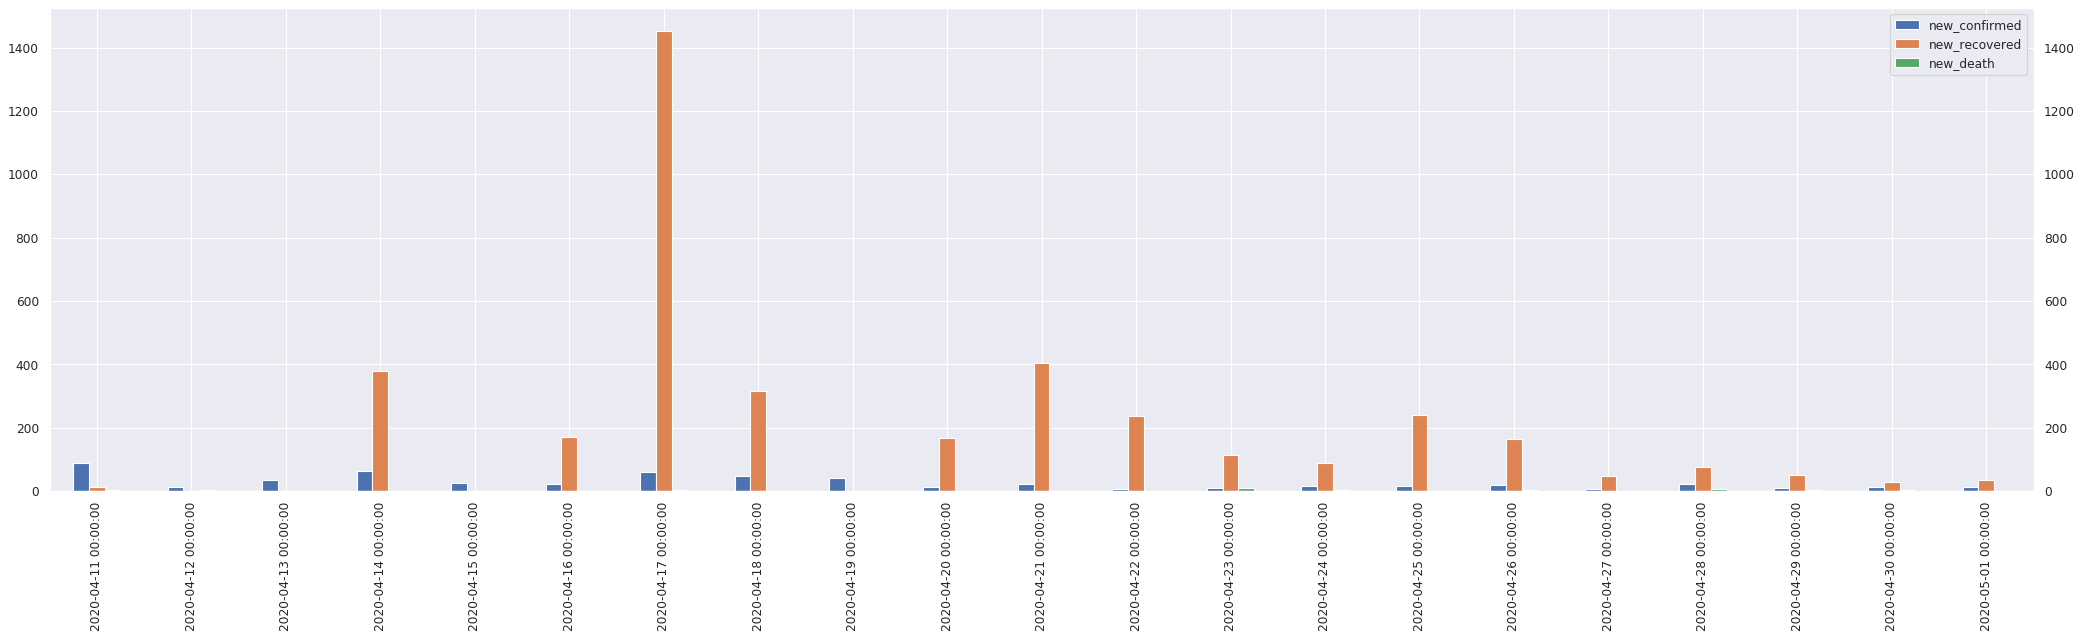

In [75]:
cbr_australia.plot_daily_stats()

In [76]:
cbr_australia.fit(first_date=pd.to_datetime('2020-03-10'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+linear: seor: 54.24317692414525, max asymptotic: 5997.626355356958; growth-rate: 0.004, date:2020-04-09 00:00:00, projected value: 75.01814354583175


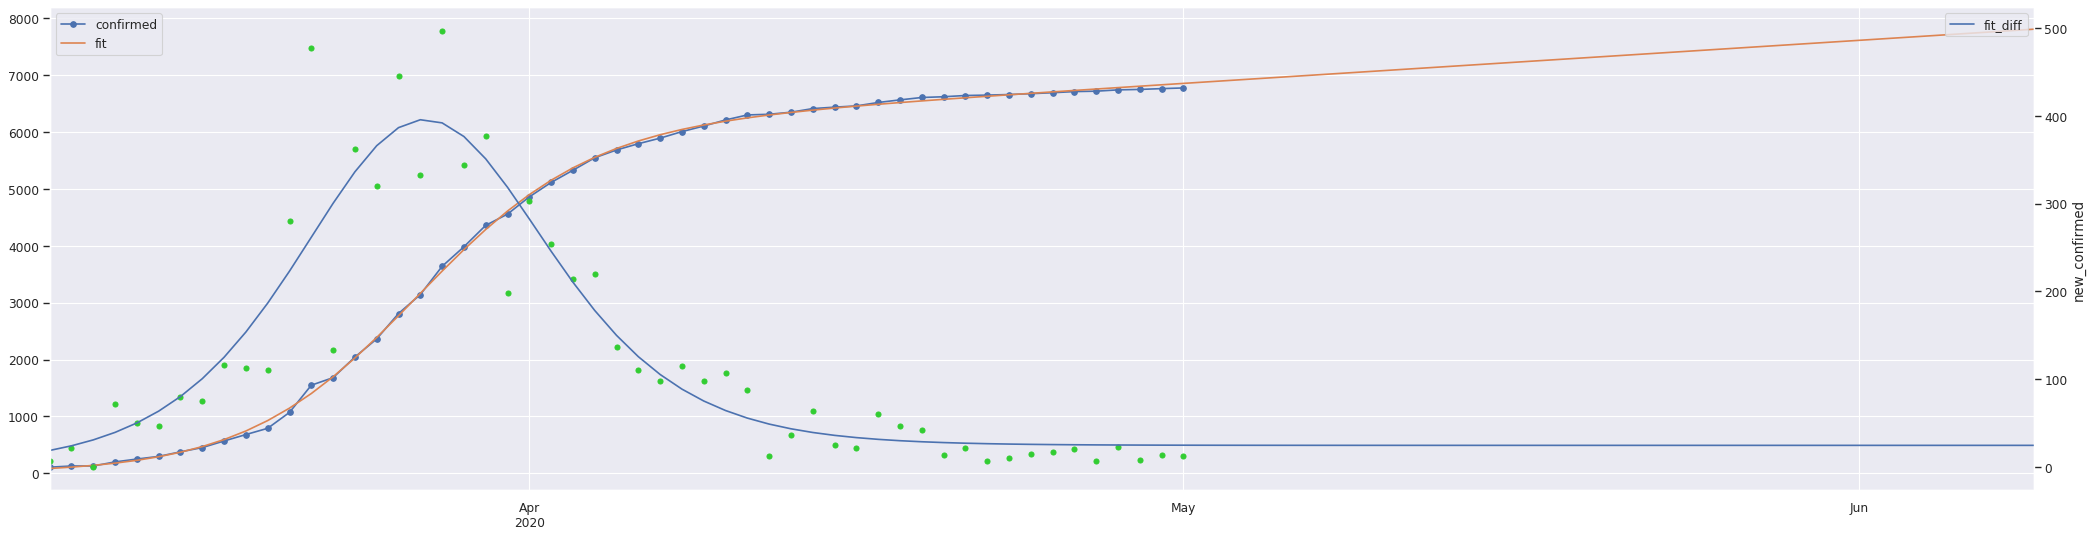

In [77]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_australia.plot_with_fits(ax=ax)

In [78]:
cbr_australia.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,395.696172


In [79]:
cbr_australia.calculate_R_estimates()
cbr_australia.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-29,0.938,0.558,1.082,0.519,0.671


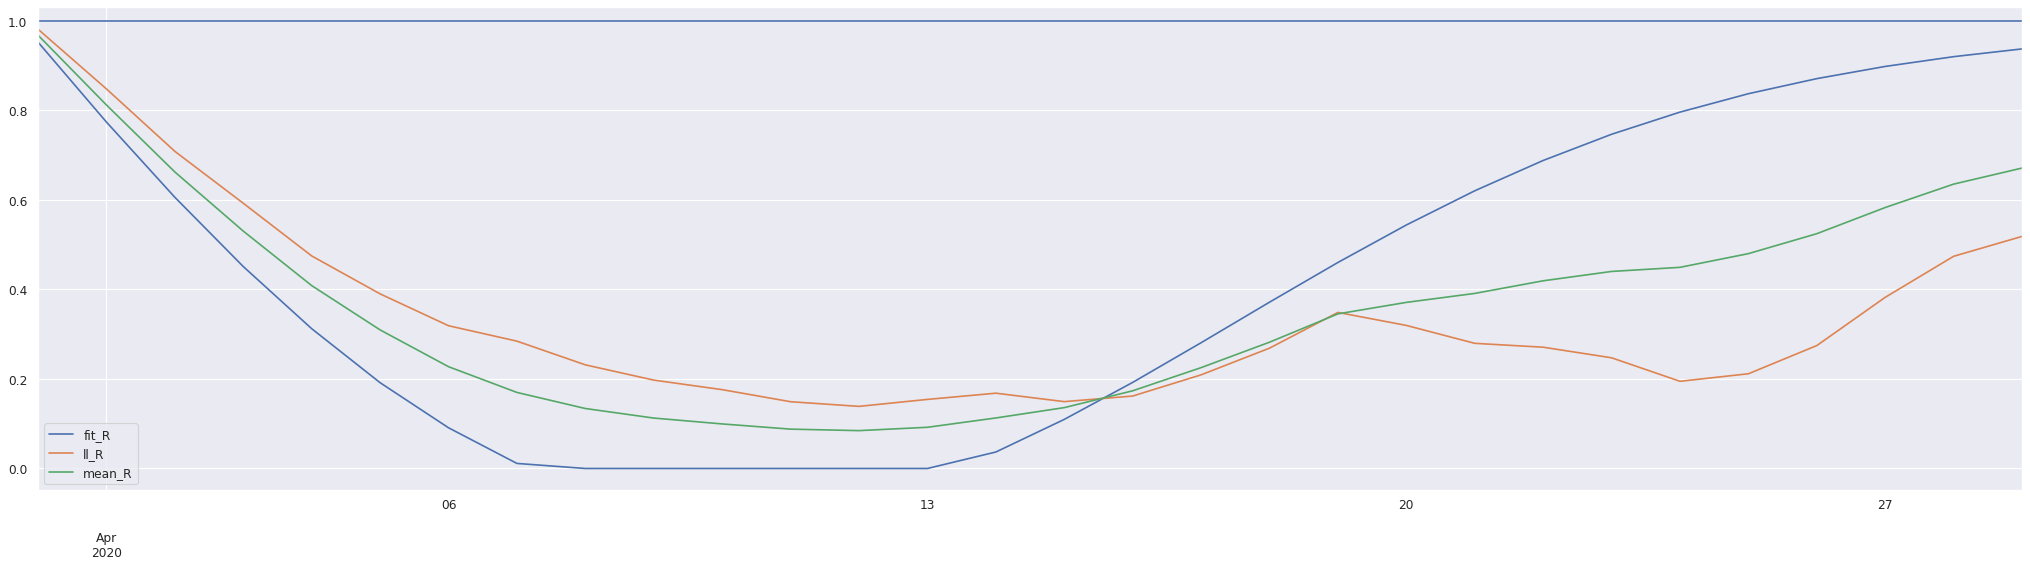

In [80]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_australia.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [81]:
df_co = covid19.get_country_overview()
df_co.head()

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-05-01,,,,,
Yemen,7,1,2,28.571429,50.000000
MS Zaandam,9,0,2,22.222222,66.666667
Nicaragua,14,7,3,21.428571,27.272727
Belgium,49032,11892,7703,15.710148,39.309043
United Kingdom,178685,892,27583,15.436662,96.864026


In [82]:
df_co[df_co.confirmed > 6500].round(1)

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-05-01,,,,,
Belgium,49032,11892,7703,15.7,39.3
United Kingdom,178685,892,27583,15.4,96.9
France,167305,50212,24597,14.7,32.9
Italy,207428,78249,28236,13.6,26.5
Sweden,21520,1005,2653,12.3,72.5
Netherlands,39989,138,4909,12.3,97.2
Spain,213435,112050,24543,11.5,18.0
Mexico,20739,12377,1972,9.5,13.7
Indonesia,10551,1591,800,7.6,33.4
